In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

In [ ]:

"""
CMSC733 Spring 2019: Classical and Deep Learning Approaches for
Geometric Computer Vision
Homework 0: Alohomora: Phase 2 Starter Code


Author(s):
Nitin J. Sanket (nitinsan@terpmail.umd.edu)
PhD Candidate in Computer Science,
University of Maryland, College Park
"""

# Dependencies:
# opencv, do (pip install opencv-python)
# skimage, do (apt install python-skimage)
# termcolor, do (pip install termcolor)

import sys
#sys.path.append('/content/drive/MyDrive/Phase2/Code/Network')
#%cd /content/drive/My\ Drive/Phase2/Code
sys.path.append('/home/rashmikapu/Downloads/YourDirectoryID_hw0(1)/YourDirectoryID_hw0/Phase2/Code/Network')
%cd /home/rashmikapu/Downloads/YourDirectoryID_hw0(1)/YourDirectoryID_hw0/Phase2/Code
import tensorflow as tf
import cv2
import sys
import os
import glob
# import Misc.ImageUtils as iu
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
from Misc.MiscUtils import *
from Misc.DataUtils import *
import numpy as np
from Network.Network import *
tf.compat.v1.disable_eager_execution()

import time
import argparse
import shutil
from io import StringIO
import string
from termcolor import colored, cprint
import math as m
from tqdm import tqdm

# Don't generate pyc codes
sys.dont_write_bytecode = True


def GenerateBatch(BasePath, DirNamesTrain, TrainLabels, ImageSize, MiniBatchSize):
  """
  Inputs:
  BasePath - Path to CIFAR10 folder without "/" at the end
  DirNamesTrain - Variable with Subfolder paths to train files
  NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
  TrainLabels - Labels corresponding to Train
  NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
  ImageSize - Size of the Image
  MiniBatchSize is the size of the MiniBatch
  Outputs:
  I1Batch - Batch of images
  LabelBatch - Batch of one-hot encoded labels
  """
  I1Batch = []
  LabelBatch = []

  ImageNum = 0
  while ImageNum < MiniBatchSize:
      # Generate random image
      RandIdx = random.randint(0, len(DirNamesTrain)-1)

      RandImageName = BasePath + os.sep + DirNamesTrain[RandIdx] + '.png'
      ImageNum += 1

    ##########################################################
    # Add any standardization or data augmentation here!
    ##########################################################

      I1 = np.float32(cv2.imread(RandImageName))
      Label = convertToOneHot(TrainLabels[RandIdx], 10)

      # Append All Images and Mask
      I1Batch.append(I1)
      LabelBatch.append(Label)

  return I1Batch, LabelBatch


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
  """
  Prints all stats with all arguments
  """
  print('Number of Epochs Training will run for ' + str(NumEpochs))
  print('Factor of reduction in training data is ' + str(DivTrain))
  print('Mini Batch Size ' + str(MiniBatchSize))
  print('Number of Training Images ' + str(NumTrainSamples))
  if LatestFile is not None:
      print('Loading latest checkpoint with the name ' + LatestFile)



def TrainOperation(ImgPH, LabelPH, DirNamesTrain, TrainLabels, NumTrainSamples, ImageSize,
                  NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                  DivTrain, LatestFile, BasePath, LogsPath):
  """
  Inputs:
  ImgPH is the Input Image placeholder
  LabelPH is the one-hot encoded label placeholder
  DirNamesTrain - Variable with Subfolder paths to train files
  TrainLabels - Labels corresponding to Train/Test
  NumTrainSamples - length(Train)
  ImageSize - Size of the image
  NumEpochs - Number of passes through the Train data
  MiniBatchSize is the size of the MiniBatch
  SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
  CheckPointPath - Path to save checkpoints/model
  DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
  LatestFile - Latest checkpointfile to continue training
  BasePath - Path to CIFAR10 folder without "/" at the end
  LogsPath - Path to save Tensorboard Logs
  Outputs:
  Saves Trained network in CheckPointPath and Logs to LogsPath
  """
  # Predict output with forward pass
  prLogits, prSoftMax = CIFAR10Resnet(ImgPH, ImageSize, MiniBatchSize)
  # model = tf.keras.Model(inputs=ImgPH, outputs=[prLogits, prSoftMax])

  with tf.compat.v1.name_scope('Loss'):
      ###############################################
      # Fill your loss function of choice here!
      ###############################################
      #cross_entropy = tf.compat.v1.nn.softmax_cross_entropy_with_logits(labels = LabelPH, logits = prLogits)
      loss = tf.compat.v1.losses.mean_squared_error(labels=LabelPH, predictions=prLogits)


  with tf.compat.v1.name_scope('Accuracy'):
      prSoftMaxDecoded = tf.argmax(prSoftMax, axis=1)
      LabelDecoded = tf.argmax(LabelPH, axis=1)
      Acc = tf.reduce_mean(tf.cast(tf.math.equal(prSoftMaxDecoded, LabelDecoded), dtype=tf.float32))

  with tf.compat.v1.name_scope('Adam'):
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
      Optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = 1e-3).minimize(loss)

  if loss is None:
    print("Loss is None")
  if Optimizer is None:
    print("Optimizer is None")
  # Tensorboard
  # Create a summary to monitor loss tensor
  tf.compat.v1.summary.scalar('LossEveryIter', loss)
  tf.compat.v1.summary.scalar('AccuracyEveryIter', Acc)

  # Merge all summaries into a single operation
  MergedSummaryOP = tf.compat.v1.summary.merge_all()

  # Setup Saver
  Saver = tf.compat.v1.train.Saver()

  with tf.compat.v1.Session() as sess:
      if LatestFile is not None:
          Saver.restore(sess, CheckPointPath + LatestFile + '.ckpt')
          # Extract only numbers from the name
          StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
          print('Loaded latest checkpoint with the name ' + LatestFile + '....')
      else:
          sess.run(tf.compat.v1.global_variables_initializer())
          StartEpoch = 0
          print('New model initialized....')

      # Tensorboard
      Writer = tf.compat.v1.summary.FileWriter(LogsPath, graph=tf.compat.v1.get_default_graph())
      acc_plot = []
      loss_plot = []
      epoch_counter = []
      for Epochs in tqdm(range(StartEpoch, NumEpochs)):
          epoch_accuracy = []
          epoch_loss = []
          NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
          for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
              I1Batch, LabelBatch = GenerateBatch(BasePath, DirNamesTrain, TrainLabels, ImageSize, MiniBatchSize)
              FeedDict = {ImgPH: I1Batch, LabelPH: LabelBatch}

              _, LossThisBatch, Summary = sess.run([Optimizer, loss, MergedSummaryOP], feed_dict=FeedDict)

              # Save checkpoint every some SaveCheckPoint's iterations
              if PerEpochCounter % SaveCheckPoint == 0:
                  # Save the Model learnt in this epoch
                  SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'
                  Saver.save(sess,  save_path=SaveName)
                  print('\n' + SaveName + ' Model Saved...')

              epoch_loss.append(LossThisBatch)
              epoch_accuracy.append(sess.run(Acc, feed_dict=FeedDict))
              # Tensorboard
              Writer.add_summary(Summary, Epochs*NumIterationsPerEpoch + PerEpochCounter)
              # If you don't flush the tensorboard doesn't update until a lot of iterations!
              Writer.flush()
          acc_plot.append(np.mean(epoch_accuracy))
          loss_plot.append(np.mean(epoch_loss))
          epoch_counter.append(Epochs+1)
          # Save model every epoch
          SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
          Saver.save(sess, save_path=SaveName)
          print('\n' + SaveName + ' Model Saved...')

      plt.subplot(1,2,1)
      plt.plot(epoch_counter,acc_plot)
      plt.title("Accuracy over epochs")

      plt.subplot(1,2,2)
      plt.plot(epoch_counter,loss_plot)
      plt.title("Loss over epochs")





/home/rashmikapu/Downloads/YourDirectoryID_hw0(1)/YourDirectoryID_hw0/Phase2/Code


2024-02-18 12:55:45.524217: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 12:55:45.586479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 12:55:45.587637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 12:55:46.564415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# For basic model
# Architecture taken : Conv, ReLu, Conv, ReLu, FCN (with Softmax)


def TrainOperation2(ImgPH, LabelPH, DirNamesTrain, TrainLabels, NumTrainSamples, ImageSize,
                  NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                  DivTrain, LatestFile, BasePath, LogsPath):
  """
  Inputs:
  ImgPH is the Input Image placeholder
  LabelPH is the one-hot encoded label placeholder
  DirNamesTrain - Variable with Subfolder paths to train files
  TrainLabels - Labels corresponding to Train/Test
  NumTrainSamples - length(Train)
  ImageSize - Size of the image
  NumEpochs - Number of passes through the Train data
  MiniBatchSize is the size of the MiniBatch
  SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
  CheckPointPath - Path to save checkpoints/model
  DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
  LatestFile - Latest checkpointfile to continue training
  BasePath - Path to CIFAR10 folder without "/" at the end
  LogsPath - Path to save Tensorboard Logs
  Outputs:
  Saves Trained network in CheckPointPath and Logs to LogsPath
  """
  # Predict output with forward pass
  prLogits, prSoftMax = CIFAR10Model(ImgPH, ImageSize, MiniBatchSize)
  # model = tf.keras.Model(inputs=ImgPH, outputs=[prLogits, prSoftMax])

  with tf.compat.v1.name_scope('Loss'):
      ###############################################
      # Fill your loss function of choice here!
      ###############################################
      #cross_entropy = tf.compat.v1.nn.softmax_cross_entropy_with_logits(labels = LabelPH, logits = prLogits)
      loss = tf.compat.v1.losses.mean_squared_error(labels=LabelPH, predictions=prLogits)


  with tf.compat.v1.name_scope('Accuracy'):
      prSoftMaxDecoded = tf.argmax(prSoftMax, axis=1)
      LabelDecoded = tf.argmax(LabelPH, axis=1)
      Acc = tf.reduce_mean(tf.cast(tf.math.equal(prSoftMaxDecoded, LabelDecoded), dtype=tf.float32))

  with tf.compat.v1.name_scope('Adam'):
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
      Optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = 1e-3).minimize(loss)

  if loss is None:
    print("Loss is None")
  if Optimizer is None:
    print("Optimizer is None")
  # Tensorboard
  # Create a summary to monitor loss tensor
  tf.compat.v1.summary.scalar('LossEveryIter', loss)
  tf.compat.v1.summary.scalar('AccuracyEveryIter', Acc)

  # Merge all summaries into a single operation
  MergedSummaryOP = tf.compat.v1.summary.merge_all()

  # Setup Saver
  Saver = tf.compat.v1.train.Saver()

  with tf.compat.v1.Session() as sess:
      if LatestFile is not None:
          Saver.restore(sess, CheckPointPath + LatestFile + '.ckpt')
          # Extract only numbers from the name
          StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
          print('Loaded latest checkpoint with the name ' + LatestFile + '....')
      else:
          sess.run(tf.compat.v1.global_variables_initializer())
          StartEpoch = 0
          print('New model initialized....')

      # Tensorboard
      Writer = tf.compat.v1.summary.FileWriter(LogsPath, graph=tf.compat.v1.get_default_graph())
      acc_plot = []
      loss_plot = []
      epoch_counter = []
      for Epochs in tqdm(range(StartEpoch, NumEpochs)):
          epoch_accuracy = []
          epoch_loss = []
          NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
          for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
              I1Batch, LabelBatch = GenerateBatch(BasePath, DirNamesTrain, TrainLabels, ImageSize, MiniBatchSize)
              FeedDict = {ImgPH: I1Batch, LabelPH: LabelBatch}

              _, LossThisBatch, Summary = sess.run([Optimizer, loss, MergedSummaryOP], feed_dict=FeedDict)

              # Save checkpoint every some SaveCheckPoint's iterations
              if PerEpochCounter % SaveCheckPoint == 0:
                  # Save the Model learnt in this epoch
                  SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'
                  Saver.save(sess,  save_path=SaveName)
                  print('\n' + SaveName + ' Model Saved...')

              epoch_loss.append(LossThisBatch)
              epoch_accuracy.append(sess.run(Acc, feed_dict=FeedDict))
              # Tensorboard
              Writer.add_summary(Summary, Epochs*NumIterationsPerEpoch + PerEpochCounter)
              # If you don't flush the tensorboard doesn't update until a lot of iterations!
              Writer.flush()
          acc_plot.append(np.mean(epoch_accuracy))
          loss_plot.append(np.mean(epoch_loss))
          epoch_counter.append(Epochs+1)
          # Save model every epoch
          SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
          Saver.save(sess, save_path=SaveName)
          print('\n' + SaveName + ' Model Saved...')

      plt.subplot(1,2,1)
      plt.plot(epoch_counter,acc_plot)
      plt.title("Accuracy over epochs")

      plt.subplot(1,2,2)
      plt.plot(epoch_counter,loss_plot)
      plt.title("Loss over epochs")





In [ ]:
print(tf.__version__)

2.13.0


Number of Epochs Training will run for 5
Factor of reduction in training data is 1.0
Mini Batch Size 8
Number of Training Images 50000
[32, 32, 3]
(8, 32, 32, 3)


/home/rashmikapu/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024-02-18 12:56:32.800726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


New model initialized....


  0%|                                          | 1/6250 [00:00<13:25,  7.76it/s]


../Checkpoints/0a0model.ckpt Model Saved...



  2%|▋                                      | 118/6250 [00:01<00:58, 104.80it/s]


../Checkpoints/0a100model.ckpt Model Saved...



  4%|█▎                                     | 219/6250 [00:02<00:57, 104.13it/s]


../Checkpoints/0a200model.ckpt Model Saved...



  5%|█▉                                     | 314/6250 [00:03<00:55, 106.90it/s]


../Checkpoints/0a300model.ckpt Model Saved...



  7%|██▌                                    | 413/6250 [00:03<00:52, 111.40it/s]


../Checkpoints/0a400model.ckpt Model Saved...



  8%|███                                    | 497/6250 [00:04<00:50, 113.86it/s]

Instructions for updating:
Use standard file APIs to delete files with this prefix.



  8%|███▎                                   | 522/6250 [00:04<00:50, 113.75it/s]


../Checkpoints/0a500model.ckpt Model Saved...



 10%|███▊                                   | 616/6250 [00:05<00:54, 102.65it/s]


../Checkpoints/0a600model.ckpt Model Saved...



 12%|████▍                                  | 720/6250 [00:06<00:48, 112.88it/s]


../Checkpoints/0a700model.ckpt Model Saved...



 13%|█████                                  | 817/6250 [00:07<00:48, 111.28it/s]


../Checkpoints/0a800model.ckpt Model Saved...



 15%|█████▋                                 | 913/6250 [00:08<00:47, 111.46it/s]


../Checkpoints/0a900model.ckpt Model Saved...



 16%|██████▏                               | 1022/6250 [00:09<00:45, 115.25it/s]


../Checkpoints/0a1000model.ckpt Model Saved...



 18%|██████▊                               | 1115/6250 [00:10<00:47, 107.34it/s]


../Checkpoints/0a1100model.ckpt Model Saved...



 19%|███████▍                              | 1213/6250 [00:11<00:43, 116.04it/s]


../Checkpoints/0a1200model.ckpt Model Saved...



 21%|████████                              | 1317/6250 [00:12<00:46, 105.66it/s]


../Checkpoints/0a1300model.ckpt Model Saved...



 23%|████████▌                             | 1415/6250 [00:13<00:43, 110.86it/s]


../Checkpoints/0a1400model.ckpt Model Saved...



 24%|█████████▏                            | 1511/6250 [00:13<00:44, 105.72it/s]



../Checkpoints/0a1500model.ckpt Model Saved...


 26%|█████████▊                            | 1621/6250 [00:14<00:38, 119.88it/s]


../Checkpoints/0a1600model.ckpt Model Saved...



 28%|██████████▍                           | 1721/6250 [00:15<00:41, 108.88it/s]


../Checkpoints/0a1700model.ckpt Model Saved...



 29%|███████████                           | 1818/6250 [00:16<00:39, 113.53it/s]


../Checkpoints/0a1800model.ckpt Model Saved...



 31%|███████████▋                          | 1919/6250 [00:17<00:42, 102.95it/s]


../Checkpoints/0a1900model.ckpt Model Saved...



 32%|████████████▎                         | 2023/6250 [00:18<00:37, 111.58it/s]


../Checkpoints/0a2000model.ckpt Model Saved...



 34%|████████████▉                         | 2119/6250 [00:19<00:36, 112.24it/s]


../Checkpoints/0a2100model.ckpt Model Saved...



 35%|█████████████▊                         | 2216/6250 [00:20<00:43, 92.98it/s]


../Checkpoints/0a2200model.ckpt Model Saved...



 37%|██████████████▍                        | 2319/6250 [00:21<00:42, 92.92it/s]


../Checkpoints/0a2300model.ckpt Model Saved...



 39%|███████████████                        | 2416/6250 [00:22<00:40, 93.87it/s]


../Checkpoints/0a2400model.ckpt Model Saved...



 40%|███████████████▋                       | 2510/6250 [00:23<00:40, 92.22it/s]


../Checkpoints/0a2500model.ckpt Model Saved...



 42%|████████████████▎                      | 2612/6250 [00:24<00:38, 95.30it/s]


../Checkpoints/0a2600model.ckpt Model Saved...



 43%|████████████████▉                      | 2714/6250 [00:25<00:38, 92.20it/s]


../Checkpoints/0a2700model.ckpt Model Saved...



 45%|█████████████████▌                     | 2814/6250 [00:26<00:37, 91.48it/s]


../Checkpoints/0a2800model.ckpt Model Saved...



 47%|██████████████████▏                    | 2918/6250 [00:27<00:35, 92.78it/s]


../Checkpoints/0a2900model.ckpt Model Saved...



 48%|██████████████████▊                    | 3012/6250 [00:28<00:33, 96.15it/s]


../Checkpoints/0a3000model.ckpt Model Saved...



 50%|███████████████████▍                   | 3119/6250 [00:29<00:34, 91.62it/s]


../Checkpoints/0a3100model.ckpt Model Saved...



 51%|████████████████████                   | 3212/6250 [00:30<00:31, 97.52it/s]


../Checkpoints/0a3200model.ckpt Model Saved...



 53%|████████████████████▋                  | 3317/6250 [00:32<00:33, 88.41it/s]


../Checkpoints/0a3300model.ckpt Model Saved...



 55%|████████████████████▊                 | 3421/6250 [00:33<00:28, 100.79it/s]


../Checkpoints/0a3400model.ckpt Model Saved...



 56%|█████████████████████▉                 | 3516/6250 [00:34<00:29, 91.22it/s]


../Checkpoints/0a3500model.ckpt Model Saved...



 58%|██████████████████████▌                | 3613/6250 [00:35<00:26, 98.27it/s]


../Checkpoints/0a3600model.ckpt Model Saved...



 60%|███████████████████████▏               | 3719/6250 [00:36<00:26, 95.16it/s]


../Checkpoints/0a3700model.ckpt Model Saved...



 61%|███████████████████████▊               | 3817/6250 [00:37<00:25, 96.88it/s]


../Checkpoints/0a3800model.ckpt Model Saved...



 63%|████████████████████████▍              | 3920/6250 [00:38<00:24, 93.51it/s]


../Checkpoints/0a3900model.ckpt Model Saved...



 64%|█████████████████████████              | 4012/6250 [00:39<00:23, 95.24it/s]


../Checkpoints/0a4000model.ckpt Model Saved...



 66%|█████████████████████████▋             | 4112/6250 [00:40<00:24, 88.85it/s]


../Checkpoints/0a4100model.ckpt Model Saved...



 68%|█████████████████████████▋            | 4220/6250 [00:41<00:20, 100.35it/s]


../Checkpoints/0a4200model.ckpt Model Saved...



 69%|██████████████████████████▉            | 4313/6250 [00:42<00:21, 92.16it/s]


../Checkpoints/0a4300model.ckpt Model Saved...



 71%|███████████████████████████▌           | 4420/6250 [00:43<00:18, 99.22it/s]


../Checkpoints/0a4400model.ckpt Model Saved...



 72%|████████████████████████████▏          | 4521/6250 [00:44<00:18, 94.94it/s]


../Checkpoints/0a4500model.ckpt Model Saved...



 74%|████████████████████████████          | 4620/6250 [00:45<00:16, 100.03it/s]


../Checkpoints/0a4600model.ckpt Model Saved...



 75%|█████████████████████████████▍         | 4712/6250 [00:46<00:16, 94.43it/s]


../Checkpoints/0a4700model.ckpt Model Saved...



 77%|█████████████████████████████▎        | 4819/6250 [00:47<00:14, 100.90it/s]


../Checkpoints/0a4800model.ckpt Model Saved...



 79%|██████████████████████████████▋        | 4921/6250 [00:48<00:13, 96.57it/s]


../Checkpoints/0a4900model.ckpt Model Saved...



 80%|██████████████████████████████▌       | 5019/6250 [00:49<00:12, 102.17it/s]


../Checkpoints/0a5000model.ckpt Model Saved...



 82%|███████████████████████████████▉       | 5111/6250 [00:50<00:11, 95.84it/s]


../Checkpoints/0a5100model.ckpt Model Saved...



 84%|████████████████████████████████▌      | 5219/6250 [00:51<00:10, 97.66it/s]


../Checkpoints/0a5200model.ckpt Model Saved...



 85%|█████████████████████████████████▏     | 5321/6250 [00:52<00:09, 96.36it/s]


../Checkpoints/0a5300model.ckpt Model Saved...



 87%|█████████████████████████████████▊     | 5420/6250 [00:53<00:08, 99.95it/s]


../Checkpoints/0a5400model.ckpt Model Saved...



 88%|██████████████████████████████████▍    | 5513/6250 [00:54<00:07, 97.67it/s]


../Checkpoints/0a5500model.ckpt Model Saved...



 90%|███████████████████████████████████    | 5619/6250 [00:55<00:06, 96.53it/s]


../Checkpoints/0a5600model.ckpt Model Saved...



 92%|███████████████████████████████████▋   | 5720/6250 [00:56<00:05, 97.61it/s]


../Checkpoints/0a5700model.ckpt Model Saved...



 93%|████████████████████████████████████▎  | 5818/6250 [00:57<00:04, 96.14it/s]


../Checkpoints/0a5800model.ckpt Model Saved...



 95%|████████████████████████████████████▉  | 5911/6250 [00:58<00:03, 98.44it/s]


../Checkpoints/0a5900model.ckpt Model Saved...



 96%|█████████████████████████████████████▌ | 6010/6250 [00:59<00:02, 93.92it/s]


../Checkpoints/0a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████▏| 6120/6250 [01:00<00:01, 94.86it/s]


../Checkpoints/0a6100model.ckpt Model Saved...



100%|██████████████████████████████████████▊| 6220/6250 [01:01<00:00, 98.03it/s]


../Checkpoints/0a6200model.ckpt Model Saved...



 20%|█████████                                    | 1/5 [01:02<04:08, 62.08s/it]


../Checkpoints/0model.ckpt Model Saved...



  0%|                                          | 8/6250 [00:00<01:20, 77.47it/s]


../Checkpoints/1a0model.ckpt Model Saved...



  2%|▋                                       | 116/6250 [00:01<01:01, 99.61it/s]


../Checkpoints/1a100model.ckpt Model Saved...



  4%|█▍                                      | 220/6250 [00:02<01:02, 95.89it/s]


../Checkpoints/1a200model.ckpt Model Saved...



  5%|█▉                                     | 317/6250 [00:03<00:58, 101.11it/s]


../Checkpoints/1a300model.ckpt Model Saved...



  7%|██▋                                     | 419/6250 [00:04<01:04, 90.93it/s]


../Checkpoints/1a400model.ckpt Model Saved...



  8%|███▎                                    | 513/6250 [00:05<00:58, 98.89it/s]


../Checkpoints/1a500model.ckpt Model Saved...



 10%|███▉                                    | 617/6250 [00:06<01:00, 92.97it/s]


../Checkpoints/1a600model.ckpt Model Saved...



 11%|████▌                                   | 712/6250 [00:07<00:58, 94.56it/s]


../Checkpoints/1a700model.ckpt Model Saved...



 13%|█████▏                                  | 814/6250 [00:08<00:56, 95.49it/s]


../Checkpoints/1a800model.ckpt Model Saved...



 15%|█████▉                                  | 919/6250 [00:09<00:55, 96.51it/s]


../Checkpoints/1a900model.ckpt Model Saved...



 16%|██████▎                                | 1020/6250 [00:10<00:55, 93.47it/s]


../Checkpoints/1a1000model.ckpt Model Saved...



 18%|██████▉                                | 1117/6250 [00:11<00:53, 96.65it/s]


../Checkpoints/1a1100model.ckpt Model Saved...



 20%|███████▌                               | 1219/6250 [00:12<00:51, 98.43it/s]


../Checkpoints/1a1200model.ckpt Model Saved...



 21%|████████▏                              | 1317/6250 [00:13<00:51, 95.61it/s]


../Checkpoints/1a1300model.ckpt Model Saved...



 23%|████████▊                              | 1411/6250 [00:14<00:49, 97.36it/s]


../Checkpoints/1a1400model.ckpt Model Saved...



 24%|█████████▍                             | 1519/6250 [00:15<00:49, 95.41it/s]


../Checkpoints/1a1500model.ckpt Model Saved...



 26%|██████████                             | 1612/6250 [00:16<00:46, 99.02it/s]


../Checkpoints/1a1600model.ckpt Model Saved...



 27%|██████████▋                            | 1716/6250 [00:17<00:48, 93.53it/s]


../Checkpoints/1a1700model.ckpt Model Saved...



 29%|███████████                           | 1821/6250 [00:18<00:43, 101.63it/s]


../Checkpoints/1a1800model.ckpt Model Saved...



 31%|███████████▉                           | 1919/6250 [00:19<00:44, 96.51it/s]


../Checkpoints/1a1900model.ckpt Model Saved...



 32%|████████████▌                          | 2019/6250 [00:20<00:44, 95.01it/s]


../Checkpoints/1a2000model.ckpt Model Saved...



 34%|█████████████▏                         | 2117/6250 [00:21<00:44, 93.05it/s]


../Checkpoints/1a2100model.ckpt Model Saved...



 35%|█████████████▊                         | 2211/6250 [00:22<00:41, 97.61it/s]


../Checkpoints/1a2200model.ckpt Model Saved...



 37%|██████████████▍                        | 2318/6250 [00:23<00:41, 94.93it/s]


../Checkpoints/1a2300model.ckpt Model Saved...



 39%|███████████████                        | 2418/6250 [00:24<00:42, 90.69it/s]


../Checkpoints/1a2400model.ckpt Model Saved...



 40%|███████████████▋                       | 2510/6250 [00:25<00:41, 90.72it/s]


../Checkpoints/1a2500model.ckpt Model Saved...



 42%|████████████████▎                      | 2613/6250 [00:26<00:38, 94.22it/s]


../Checkpoints/1a2600model.ckpt Model Saved...



 43%|████████████████▉                      | 2714/6250 [00:28<00:38, 92.67it/s]


../Checkpoints/1a2700model.ckpt Model Saved...



 45%|█████████████████▌                     | 2812/6250 [00:29<00:35, 97.92it/s]


../Checkpoints/1a2800model.ckpt Model Saved...



 47%|██████████████████▏                    | 2919/6250 [00:30<00:35, 94.43it/s]


../Checkpoints/1a2900model.ckpt Model Saved...



 48%|██████████████████▊                    | 3017/6250 [00:31<00:32, 98.59it/s]


../Checkpoints/1a3000model.ckpt Model Saved...



 50%|███████████████████▍                   | 3112/6250 [00:32<00:34, 91.81it/s]


../Checkpoints/1a3100model.ckpt Model Saved...



 52%|███████████████████▌                  | 3222/6250 [00:33<00:29, 102.86it/s]


../Checkpoints/1a3200model.ckpt Model Saved...



 53%|████████████████████▋                  | 3315/6250 [00:34<00:31, 92.04it/s]


../Checkpoints/1a3300model.ckpt Model Saved...



 55%|█████████████████████▎                 | 3420/6250 [00:35<00:28, 97.74it/s]


../Checkpoints/1a3400model.ckpt Model Saved...



 56%|█████████████████████▉                 | 3511/6250 [00:36<00:29, 93.68it/s]


../Checkpoints/1a3500model.ckpt Model Saved...



 58%|██████████████████████▌                | 3618/6250 [00:37<00:27, 94.69it/s]


../Checkpoints/1a3600model.ckpt Model Saved...



 60%|███████████████████████▏               | 3721/6250 [00:38<00:26, 95.47it/s]


../Checkpoints/1a3700model.ckpt Model Saved...



 61%|███████████████████████▊               | 3818/6250 [00:39<00:24, 99.75it/s]


../Checkpoints/1a3800model.ckpt Model Saved...



 63%|████████████████████████▍              | 3921/6250 [00:40<00:24, 94.51it/s]


../Checkpoints/1a3900model.ckpt Model Saved...



 64%|████████████████████████▍             | 4020/6250 [00:41<00:22, 100.76it/s]


../Checkpoints/1a4000model.ckpt Model Saved...



 66%|█████████████████████████▋             | 4111/6250 [00:42<00:22, 95.80it/s]


../Checkpoints/1a4100model.ckpt Model Saved...



 68%|█████████████████████████▋            | 4221/6250 [00:43<00:20, 100.53it/s]


../Checkpoints/1a4200model.ckpt Model Saved...



 69%|██████████████████████████▉            | 4313/6250 [00:44<00:20, 94.80it/s]


../Checkpoints/1a4300model.ckpt Model Saved...



 71%|███████████████████████████▌           | 4420/6250 [00:45<00:18, 97.03it/s]


../Checkpoints/1a4400model.ckpt Model Saved...



 72%|████████████████████████████▏          | 4511/6250 [00:46<00:18, 95.54it/s]


../Checkpoints/1a4500model.ckpt Model Saved...



 74%|████████████████████████████▊          | 4620/6250 [00:47<00:16, 97.71it/s]


../Checkpoints/1a4600model.ckpt Model Saved...



 75%|█████████████████████████████▍         | 4712/6250 [00:48<00:15, 98.05it/s]


../Checkpoints/1a4700model.ckpt Model Saved...



 77%|█████████████████████████████▎        | 4821/6250 [00:49<00:14, 100.34it/s]


../Checkpoints/1a4800model.ckpt Model Saved...



 79%|██████████████████████████████▋        | 4914/6250 [00:50<00:13, 98.51it/s]


../Checkpoints/1a4900model.ckpt Model Saved...



 80%|███████████████████████████████▎       | 5014/6250 [00:51<00:12, 97.31it/s]


../Checkpoints/1a5000model.ckpt Model Saved...



 82%|███████████████████████████████▉       | 5116/6250 [00:52<00:11, 95.99it/s]


../Checkpoints/1a5100model.ckpt Model Saved...



 83%|████████████████████████████████▌      | 5211/6250 [00:53<00:10, 96.40it/s]


../Checkpoints/1a5200model.ckpt Model Saved...



 85%|█████████████████████████████████▏     | 5313/6250 [00:54<00:09, 99.35it/s]


../Checkpoints/1a5300model.ckpt Model Saved...



 87%|█████████████████████████████████▊     | 5412/6250 [00:55<00:08, 99.43it/s]


../Checkpoints/1a5400model.ckpt Model Saved...



 88%|██████████████████████████████████▍    | 5515/6250 [00:56<00:07, 97.25it/s]


../Checkpoints/1a5500model.ckpt Model Saved...



 90%|███████████████████████████████████    | 5613/6250 [00:57<00:06, 96.10it/s]


../Checkpoints/1a5600model.ckpt Model Saved...



 91%|███████████████████████████████████▋   | 5716/6250 [00:58<00:05, 99.05it/s]


../Checkpoints/1a5700model.ckpt Model Saved...



 93%|████████████████████████████████████▎  | 5812/6250 [00:59<00:04, 94.65it/s]


../Checkpoints/1a5800model.ckpt Model Saved...



 95%|███████████████████████████████████▉  | 5920/6250 [01:00<00:03, 100.65it/s]


../Checkpoints/1a5900model.ckpt Model Saved...



 96%|█████████████████████████████████████▌ | 6018/6250 [01:01<00:02, 96.33it/s]


../Checkpoints/1a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████▏| 6111/6250 [01:02<00:01, 96.35it/s]


../Checkpoints/1a6100model.ckpt Model Saved...



 99%|██████████████████████████████████████▊| 6210/6250 [01:03<00:00, 94.38it/s]


../Checkpoints/1a6200model.ckpt Model Saved...



 40%|██████████████████                           | 2/5 [02:06<03:09, 63.23s/it]


../Checkpoints/1model.ckpt Model Saved...



  0%|                                          | 8/6250 [00:00<01:20, 77.83it/s]


../Checkpoints/2a0model.ckpt Model Saved...



  2%|▋                                       | 116/6250 [00:01<01:01, 99.16it/s]


../Checkpoints/2a100model.ckpt Model Saved...



  3%|█▍                                      | 216/6250 [00:02<01:04, 94.09it/s]


../Checkpoints/2a200model.ckpt Model Saved...



  5%|██                                      | 313/6250 [00:03<01:00, 97.38it/s]


../Checkpoints/2a300model.ckpt Model Saved...



  7%|██▋                                     | 414/6250 [00:04<01:02, 92.75it/s]


../Checkpoints/2a400model.ckpt Model Saved...



  8%|███▎                                    | 511/6250 [00:05<00:58, 98.42it/s]


../Checkpoints/2a500model.ckpt Model Saved...



 10%|███▉                                    | 612/6250 [00:06<00:59, 95.35it/s]


../Checkpoints/2a600model.ckpt Model Saved...



 11%|████▌                                   | 718/6250 [00:07<00:57, 96.36it/s]


../Checkpoints/2a700model.ckpt Model Saved...



 13%|█████▏                                  | 818/6250 [00:08<00:57, 94.30it/s]


../Checkpoints/2a800model.ckpt Model Saved...



 15%|█████▊                                  | 913/6250 [00:09<00:54, 98.53it/s]


../Checkpoints/2a900model.ckpt Model Saved...



 16%|██████▎                                | 1014/6250 [00:10<00:53, 96.98it/s]


../Checkpoints/2a1000model.ckpt Model Saved...



 18%|██████▉                                | 1112/6250 [00:11<00:52, 98.53it/s]


../Checkpoints/2a1100model.ckpt Model Saved...



 19%|███████▌                               | 1215/6250 [00:12<00:51, 98.24it/s]


../Checkpoints/2a1200model.ckpt Model Saved...



 21%|████████▏                              | 1314/6250 [00:13<00:49, 98.84it/s]


../Checkpoints/2a1300model.ckpt Model Saved...



 23%|████████▊                              | 1417/6250 [00:14<00:50, 95.97it/s]


../Checkpoints/2a1400model.ckpt Model Saved...



 24%|█████████▍                             | 1514/6250 [00:15<00:48, 97.38it/s]


../Checkpoints/2a1500model.ckpt Model Saved...



 26%|█████████▊                            | 1619/6250 [00:16<00:46, 100.06it/s]


../Checkpoints/2a1600model.ckpt Model Saved...



 27%|██████████▋                            | 1717/6250 [00:17<00:46, 96.73it/s]


../Checkpoints/2a1700model.ckpt Model Saved...



 29%|███████████▎                           | 1820/6250 [00:18<00:45, 96.80it/s]


../Checkpoints/2a1800model.ckpt Model Saved...



 31%|███████████▉                           | 1917/6250 [00:19<00:44, 98.45it/s]


../Checkpoints/2a1900model.ckpt Model Saved...



 32%|████████████▎                         | 2020/6250 [00:20<00:42, 100.39it/s]


../Checkpoints/2a2000model.ckpt Model Saved...



 34%|█████████████▏                         | 2114/6250 [00:21<00:43, 94.16it/s]


../Checkpoints/2a2100model.ckpt Model Saved...



 36%|█████████████▊                         | 2219/6250 [00:22<00:40, 99.10it/s]


../Checkpoints/2a2200model.ckpt Model Saved...



 37%|██████████████▍                        | 2317/6250 [00:23<00:41, 95.73it/s]


../Checkpoints/2a2300model.ckpt Model Saved...



 39%|██████████████▋                       | 2412/6250 [00:24<00:38, 100.89it/s]


../Checkpoints/2a2400model.ckpt Model Saved...



 40%|███████████████▋                       | 2511/6250 [00:25<00:40, 91.35it/s]


../Checkpoints/2a2500model.ckpt Model Saved...



 42%|████████████████▎                      | 2615/6250 [00:26<00:37, 97.63it/s]


../Checkpoints/2a2600model.ckpt Model Saved...



 44%|████████████████▉                      | 2720/6250 [00:27<00:37, 94.86it/s]


../Checkpoints/2a2700model.ckpt Model Saved...



 45%|█████████████████▌                     | 2815/6250 [00:28<00:34, 99.37it/s]


../Checkpoints/2a2800model.ckpt Model Saved...



 47%|██████████████████▏                    | 2911/6250 [00:29<00:36, 92.48it/s]


../Checkpoints/2a2900model.ckpt Model Saved...



 48%|██████████████████▊                    | 3017/6250 [00:30<00:33, 97.33it/s]


../Checkpoints/2a3000model.ckpt Model Saved...



 50%|███████████████████▍                   | 3113/6250 [00:31<00:32, 96.04it/s]


../Checkpoints/2a3100model.ckpt Model Saved...



 51%|████████████████████                   | 3211/6250 [00:32<00:31, 97.94it/s]


../Checkpoints/2a3200model.ckpt Model Saved...



 53%|████████████████████▋                  | 3316/6250 [00:33<00:31, 93.38it/s]


../Checkpoints/2a3300model.ckpt Model Saved...



 55%|█████████████████████▎                 | 3420/6250 [00:34<00:28, 99.60it/s]


../Checkpoints/2a3400model.ckpt Model Saved...



 56%|█████████████████████▉                 | 3514/6250 [00:35<00:28, 94.58it/s]


../Checkpoints/2a3500model.ckpt Model Saved...



 58%|██████████████████████▌                | 3620/6250 [00:37<00:27, 97.34it/s]


../Checkpoints/2a3600model.ckpt Model Saved...



 59%|███████████████████████▏               | 3711/6250 [00:37<00:27, 92.85it/s]


../Checkpoints/2a3700model.ckpt Model Saved...



 61%|███████████████████████▊               | 3816/6250 [00:39<00:24, 99.28it/s]


../Checkpoints/2a3800model.ckpt Model Saved...



 63%|████████████████████████▍              | 3919/6250 [00:40<00:24, 93.69it/s]


../Checkpoints/2a3900model.ckpt Model Saved...



 64%|████████████████████████▍             | 4018/6250 [00:41<00:22, 100.22it/s]


../Checkpoints/2a4000model.ckpt Model Saved...



 66%|█████████████████████████▋             | 4114/6250 [00:42<00:22, 93.69it/s]


../Checkpoints/2a4100model.ckpt Model Saved...



 68%|█████████████████████████▋            | 4221/6250 [00:43<00:19, 101.77it/s]


../Checkpoints/2a4200model.ckpt Model Saved...



 69%|██████████████████████████▉            | 4318/6250 [00:44<00:20, 96.48it/s]


../Checkpoints/2a4300model.ckpt Model Saved...



 71%|██████████████████████████▊           | 4416/6250 [00:45<00:18, 100.79it/s]


../Checkpoints/2a4400model.ckpt Model Saved...



 72%|████████████████████████████▏          | 4512/6250 [00:46<00:18, 95.39it/s]


../Checkpoints/2a4500model.ckpt Model Saved...



 74%|████████████████████████████▊          | 4620/6250 [00:47<00:16, 99.94it/s]


../Checkpoints/2a4600model.ckpt Model Saved...



 75%|█████████████████████████████▍         | 4714/6250 [00:48<00:16, 93.80it/s]


../Checkpoints/2a4700model.ckpt Model Saved...



 77%|██████████████████████████████         | 4811/6250 [00:49<00:14, 98.22it/s]


../Checkpoints/2a4800model.ckpt Model Saved...



 79%|██████████████████████████████▋        | 4916/6250 [00:50<00:13, 95.29it/s]


../Checkpoints/2a4900model.ckpt Model Saved...



 80%|███████████████████████████████▎       | 5013/6250 [00:51<00:12, 97.86it/s]


../Checkpoints/2a5000model.ckpt Model Saved...



 82%|███████████████████████████████▉       | 5116/6250 [00:52<00:11, 95.19it/s]


../Checkpoints/2a5100model.ckpt Model Saved...



 83%|████████████████████████████████▌      | 5215/6250 [00:53<00:10, 99.46it/s]


../Checkpoints/2a5200model.ckpt Model Saved...



 85%|█████████████████████████████████▏     | 5311/6250 [00:54<00:10, 93.66it/s]


../Checkpoints/2a5300model.ckpt Model Saved...



 87%|████████████████████████████████▉     | 5421/6250 [00:55<00:08, 101.90it/s]


../Checkpoints/2a5400model.ckpt Model Saved...



 88%|██████████████████████████████████▍    | 5517/6250 [00:56<00:07, 94.64it/s]


../Checkpoints/2a5500model.ckpt Model Saved...



 90%|██████████████████████████████████▏   | 5615/6250 [00:57<00:06, 100.47it/s]


../Checkpoints/2a5600model.ckpt Model Saved...



 91%|███████████████████████████████████▋   | 5717/6250 [00:58<00:05, 96.56it/s]


../Checkpoints/2a5700model.ckpt Model Saved...



 93%|███████████████████████████████████▎  | 5815/6250 [00:59<00:04, 100.90it/s]


../Checkpoints/2a5800model.ckpt Model Saved...



 95%|████████████████████████████████████▉  | 5921/6250 [01:00<00:03, 96.89it/s]


../Checkpoints/2a5900model.ckpt Model Saved...



 96%|████████████████████████████████████▌ | 6020/6250 [01:01<00:02, 100.32it/s]


../Checkpoints/2a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████▏| 6113/6250 [01:02<00:01, 95.46it/s]


../Checkpoints/2a6100model.ckpt Model Saved...



100%|██████████████████████████████████████▊| 6220/6250 [01:03<00:00, 94.55it/s]


../Checkpoints/2a6200model.ckpt Model Saved...



 60%|███████████████████████████                  | 3/5 [03:09<02:06, 63.46s/it]


../Checkpoints/2model.ckpt Model Saved...



  0%|                                          | 3/6250 [00:00<03:32, 29.35it/s]


../Checkpoints/3a0model.ckpt Model Saved...



  2%|▋                                       | 112/6250 [00:01<01:15, 80.96it/s]


../Checkpoints/3a100model.ckpt Model Saved...



  3%|█▎                                      | 214/6250 [00:02<01:04, 93.48it/s]


../Checkpoints/3a200model.ckpt Model Saved...



  5%|██                                      | 320/6250 [00:03<01:02, 94.76it/s]


../Checkpoints/3a300model.ckpt Model Saved...



  7%|██▋                                     | 411/6250 [00:04<01:06, 87.41it/s]


../Checkpoints/3a400model.ckpt Model Saved...



  8%|███▏                                   | 519/6250 [00:05<00:57, 100.12it/s]


../Checkpoints/3a500model.ckpt Model Saved...



 10%|███▉                                    | 613/6250 [00:06<00:59, 95.46it/s]


../Checkpoints/3a600model.ckpt Model Saved...



 11%|████▌                                   | 711/6250 [00:07<00:56, 98.27it/s]


../Checkpoints/3a700model.ckpt Model Saved...



 13%|█████▏                                  | 813/6250 [00:08<00:57, 94.09it/s]


../Checkpoints/3a800model.ckpt Model Saved...



 15%|█████▉                                  | 919/6250 [00:09<00:54, 98.41it/s]


../Checkpoints/3a900model.ckpt Model Saved...



 16%|██████▎                                | 1011/6250 [00:10<00:55, 93.99it/s]


../Checkpoints/3a1000model.ckpt Model Saved...



 18%|██████▉                                | 1118/6250 [00:11<00:53, 95.39it/s]


../Checkpoints/3a1100model.ckpt Model Saved...



 19%|███████▌                               | 1211/6250 [00:12<00:52, 95.27it/s]


../Checkpoints/3a1200model.ckpt Model Saved...



 21%|████████▏                              | 1318/6250 [00:13<00:50, 96.81it/s]


../Checkpoints/3a1300model.ckpt Model Saved...



 23%|████████▊                              | 1412/6250 [00:14<00:48, 98.85it/s]


../Checkpoints/3a1400model.ckpt Model Saved...



 24%|█████████▍                             | 1521/6250 [00:15<00:47, 99.67it/s]


../Checkpoints/3a1500model.ckpt Model Saved...



 26%|██████████                             | 1615/6250 [00:16<00:47, 98.51it/s]


../Checkpoints/3a1600model.ckpt Model Saved...



 27%|██████████▋                            | 1713/6250 [00:17<00:46, 96.99it/s]


../Checkpoints/3a1700model.ckpt Model Saved...



 29%|███████████▎                           | 1818/6250 [00:18<00:44, 99.36it/s]


../Checkpoints/3a1800model.ckpt Model Saved...



 31%|███████████▉                           | 1916/6250 [00:19<00:44, 97.19it/s]


../Checkpoints/3a1900model.ckpt Model Saved...



 32%|████████████▎                         | 2020/6250 [00:20<00:41, 100.74it/s]


../Checkpoints/3a2000model.ckpt Model Saved...



 34%|█████████████▏                         | 2118/6250 [00:21<00:41, 98.83it/s]


../Checkpoints/3a2100model.ckpt Model Saved...



 36%|█████████████▊                         | 2221/6250 [00:22<00:42, 95.14it/s]


../Checkpoints/3a2200model.ckpt Model Saved...



 37%|██████████████▍                        | 2319/6250 [00:23<00:41, 95.40it/s]


../Checkpoints/3a2300model.ckpt Model Saved...



 39%|███████████████                        | 2412/6250 [00:24<00:40, 95.70it/s]


../Checkpoints/3a2400model.ckpt Model Saved...



 40%|███████████████▋                       | 2520/6250 [00:25<00:39, 94.85it/s]


../Checkpoints/3a2500model.ckpt Model Saved...



 42%|████████████████▎                      | 2611/6250 [00:26<00:38, 93.45it/s]


../Checkpoints/3a2600model.ckpt Model Saved...



 43%|████████████████▉                      | 2713/6250 [00:27<00:37, 94.63it/s]


../Checkpoints/3a2700model.ckpt Model Saved...



 45%|█████████████████▏                    | 2820/6250 [00:29<00:33, 102.07it/s]


../Checkpoints/3a2800model.ckpt Model Saved...



 47%|██████████████████▏                    | 2917/6250 [00:30<00:35, 93.99it/s]


../Checkpoints/3a2900model.ckpt Model Saved...



 48%|██████████████████▊                    | 3011/6250 [00:31<00:34, 93.64it/s]


../Checkpoints/3a3000model.ckpt Model Saved...



 50%|███████████████████▍                   | 3116/6250 [00:32<00:33, 94.48it/s]


../Checkpoints/3a3100model.ckpt Model Saved...



 51%|███████████████████▌                  | 3212/6250 [00:33<00:30, 100.52it/s]


../Checkpoints/3a3200model.ckpt Model Saved...



 53%|████████████████████▋                  | 3319/6250 [00:34<00:31, 93.69it/s]


../Checkpoints/3a3300model.ckpt Model Saved...



 55%|████████████████████▊                 | 3416/6250 [00:35<00:28, 100.32it/s]


../Checkpoints/3a3400model.ckpt Model Saved...



 56%|█████████████████████▉                 | 3512/6250 [00:36<00:28, 95.25it/s]


../Checkpoints/3a3500model.ckpt Model Saved...



 58%|██████████████████████                | 3621/6250 [00:37<00:26, 100.57it/s]


../Checkpoints/3a3600model.ckpt Model Saved...



 59%|███████████████████████▏               | 3717/6250 [00:38<00:26, 95.09it/s]


../Checkpoints/3a3700model.ckpt Model Saved...



 61%|███████████████████████▊               | 3812/6250 [00:39<00:24, 97.95it/s]


../Checkpoints/3a3800model.ckpt Model Saved...



 63%|████████████████████████▍              | 3911/6250 [00:40<00:24, 96.05it/s]


../Checkpoints/3a3900model.ckpt Model Saved...



 64%|████████████████████████▍             | 4018/6250 [00:41<00:22, 100.06it/s]


../Checkpoints/3a4000model.ckpt Model Saved...



 66%|█████████████████████████▋             | 4115/6250 [00:42<00:22, 96.03it/s]


../Checkpoints/3a4100model.ckpt Model Saved...



 68%|█████████████████████████▋            | 4222/6250 [00:43<00:20, 101.00it/s]


../Checkpoints/3a4200model.ckpt Model Saved...



 69%|██████████████████████████▉            | 4319/6250 [00:44<00:20, 94.01it/s]


../Checkpoints/3a4300model.ckpt Model Saved...



 71%|███████████████████████████▌           | 4417/6250 [00:45<00:18, 99.50it/s]


../Checkpoints/3a4400model.ckpt Model Saved...



 72%|████████████████████████████▏          | 4515/6250 [00:46<00:18, 96.00it/s]


../Checkpoints/3a4500model.ckpt Model Saved...



 74%|████████████████████████████▊          | 4621/6250 [00:47<00:16, 99.41it/s]


../Checkpoints/3a4600model.ckpt Model Saved...



 75%|█████████████████████████████▍         | 4713/6250 [00:48<00:16, 92.55it/s]


../Checkpoints/3a4700model.ckpt Model Saved...



 77%|██████████████████████████████         | 4815/6250 [00:49<00:14, 96.50it/s]


../Checkpoints/3a4800model.ckpt Model Saved...



 79%|██████████████████████████████▋        | 4918/6250 [00:50<00:14, 93.41it/s]


../Checkpoints/3a4900model.ckpt Model Saved...



 80%|███████████████████████████████▎       | 5015/6250 [00:51<00:12, 98.17it/s]


../Checkpoints/3a5000model.ckpt Model Saved...



 82%|███████████████████████████████▉       | 5111/6250 [00:52<00:11, 95.61it/s]


../Checkpoints/3a5100model.ckpt Model Saved...



 84%|████████████████████████████████▌      | 5220/6250 [00:53<00:10, 97.23it/s]


../Checkpoints/3a5200model.ckpt Model Saved...



 85%|█████████████████████████████████▏     | 5311/6250 [00:54<00:10, 89.64it/s]


../Checkpoints/3a5300model.ckpt Model Saved...



 87%|████████████████████████████████▉     | 5411/6250 [00:55<00:08, 100.80it/s]



../Checkpoints/3a5400model.ckpt Model Saved...


 88%|██████████████████████████████████▍    | 5516/6250 [00:56<00:07, 93.96it/s]


../Checkpoints/3a5500model.ckpt Model Saved...



 90%|██████████████████████████████████▏   | 5614/6250 [00:57<00:06, 100.01it/s]


../Checkpoints/3a5600model.ckpt Model Saved...



 92%|███████████████████████████████████▋   | 5720/6250 [00:58<00:05, 96.43it/s]


../Checkpoints/3a5700model.ckpt Model Saved...



 93%|████████████████████████████████████▎  | 5817/6250 [00:59<00:04, 98.52it/s]


../Checkpoints/3a5800model.ckpt Model Saved...



 95%|████████████████████████████████████▉  | 5913/6250 [01:00<00:03, 91.99it/s]


../Checkpoints/3a5900model.ckpt Model Saved...



 96%|█████████████████████████████████████▌ | 6018/6250 [01:01<00:02, 95.49it/s]


../Checkpoints/3a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████▏| 6121/6250 [01:02<00:01, 93.22it/s]


../Checkpoints/3a6100model.ckpt Model Saved...



100%|██████████████████████████████████████▊| 6220/6250 [01:03<00:00, 99.57it/s]


../Checkpoints/3a6200model.ckpt Model Saved...



 80%|████████████████████████████████████         | 4/5 [04:13<01:03, 63.62s/it]


../Checkpoints/3model.ckpt Model Saved...



  0%|                                         | 10/6250 [00:00<01:06, 94.11it/s]


../Checkpoints/4a0model.ckpt Model Saved...



  2%|▋                                       | 114/6250 [00:01<01:02, 98.51it/s]


../Checkpoints/4a100model.ckpt Model Saved...



  3%|█▎                                      | 211/6250 [00:02<01:03, 95.76it/s]


../Checkpoints/4a200model.ckpt Model Saved...



  5%|█▉                                     | 316/6250 [00:03<00:58, 100.65it/s]


../Checkpoints/4a300model.ckpt Model Saved...



  7%|██▋                                     | 414/6250 [00:04<01:01, 94.58it/s]


../Checkpoints/4a400model.ckpt Model Saved...



  8%|███▎                                    | 519/6250 [00:05<00:58, 97.31it/s]


../Checkpoints/4a500model.ckpt Model Saved...



 10%|███▉                                    | 616/6250 [00:06<01:00, 92.48it/s]


../Checkpoints/4a600model.ckpt Model Saved...



 11%|████▌                                   | 711/6250 [00:07<00:55, 99.68it/s]


../Checkpoints/4a700model.ckpt Model Saved...



 13%|█████▏                                  | 814/6250 [00:08<00:57, 94.61it/s]


../Checkpoints/4a800model.ckpt Model Saved...



 15%|█████▊                                  | 911/6250 [00:09<00:54, 97.53it/s]


../Checkpoints/4a900model.ckpt Model Saved...



 16%|██████▎                                | 1018/6250 [00:10<00:54, 95.26it/s]


../Checkpoints/4a1000model.ckpt Model Saved...



 18%|██████▉                                | 1114/6250 [00:11<00:53, 96.24it/s]


../Checkpoints/4a1100model.ckpt Model Saved...



 20%|███████▌                               | 1219/6250 [00:12<00:55, 90.87it/s]


../Checkpoints/4a1200model.ckpt Model Saved...



 21%|████████                              | 1316/6250 [00:13<00:49, 100.68it/s]


../Checkpoints/4a1300model.ckpt Model Saved...



 23%|████████▊                              | 1411/6250 [00:14<00:50, 95.17it/s]


../Checkpoints/4a1400model.ckpt Model Saved...



 24%|█████████▍                             | 1519/6250 [00:15<00:48, 97.82it/s]


../Checkpoints/4a1500model.ckpt Model Saved...



 26%|██████████                             | 1614/6250 [00:16<00:48, 96.40it/s]


../Checkpoints/4a1600model.ckpt Model Saved...



 27%|██████████▋                            | 1712/6250 [00:17<00:45, 99.68it/s]


../Checkpoints/4a1700model.ckpt Model Saved...



 29%|███████████▎                           | 1821/6250 [00:18<00:45, 96.90it/s]


../Checkpoints/4a1800model.ckpt Model Saved...



 31%|███████████▉                           | 1915/6250 [00:19<00:43, 99.02it/s]


../Checkpoints/4a1900model.ckpt Model Saved...



 32%|████████████▌                          | 2018/6250 [00:20<00:44, 94.93it/s]


../Checkpoints/4a2000model.ckpt Model Saved...



 34%|████████████▊                         | 2116/6250 [00:21<00:41, 100.02it/s]


../Checkpoints/4a2100model.ckpt Model Saved...



 35%|█████████████▊                         | 2214/6250 [00:22<00:42, 94.90it/s]


../Checkpoints/4a2200model.ckpt Model Saved...



 37%|██████████████▍                        | 2310/6250 [00:23<00:43, 89.69it/s]


../Checkpoints/4a2300model.ckpt Model Saved...



 39%|███████████████                        | 2412/6250 [00:24<00:41, 92.69it/s]


../Checkpoints/4a2400model.ckpt Model Saved...



 40%|███████████████▋                       | 2520/6250 [00:25<00:38, 98.02it/s]


../Checkpoints/4a2500model.ckpt Model Saved...



 42%|████████████████▎                      | 2612/6250 [00:26<00:38, 93.57it/s]


../Checkpoints/4a2600model.ckpt Model Saved...



 43%|████████████████▉                      | 2717/6250 [00:27<00:36, 96.72it/s]


../Checkpoints/4a2700model.ckpt Model Saved...



 45%|█████████████████▌                     | 2818/6250 [00:28<00:35, 96.04it/s]


../Checkpoints/4a2800model.ckpt Model Saved...



 47%|█████████████████▋                    | 2917/6250 [00:29<00:33, 100.71it/s]


../Checkpoints/4a2900model.ckpt Model Saved...



 48%|██████████████████▊                    | 3020/6250 [00:30<00:33, 96.12it/s]


../Checkpoints/4a3000model.ckpt Model Saved...



 50%|███████████████████▍                   | 3118/6250 [00:31<00:31, 98.44it/s]


../Checkpoints/4a3100model.ckpt Model Saved...



 51%|███████████████████▌                  | 3214/6250 [00:32<00:30, 100.51it/s]


../Checkpoints/4a3200model.ckpt Model Saved...



 53%|████████████████████▋                  | 3311/6250 [00:33<00:30, 95.97it/s]


../Checkpoints/4a3300model.ckpt Model Saved...



 55%|█████████████████████▎                 | 3413/6250 [00:34<00:28, 98.59it/s]


../Checkpoints/4a3400model.ckpt Model Saved...



 56%|█████████████████████▉                 | 3511/6250 [00:35<00:28, 97.19it/s]



../Checkpoints/4a3500model.ckpt Model Saved...


 58%|██████████████████████▌                | 3613/6250 [00:36<00:26, 97.79it/s]


../Checkpoints/4a3600model.ckpt Model Saved...



 59%|██████████████████████▌               | 3713/6250 [00:37<00:24, 102.71it/s]


../Checkpoints/4a3700model.ckpt Model Saved...



 61%|███████████████████████▊               | 3816/6250 [00:38<00:25, 95.68it/s]


../Checkpoints/4a3800model.ckpt Model Saved...



 63%|████████████████████████▍              | 3914/6250 [00:39<00:23, 98.90it/s]


../Checkpoints/4a3900model.ckpt Model Saved...



 64%|████████████████████████▍             | 4019/6250 [00:40<00:22, 101.30it/s]


../Checkpoints/4a4000model.ckpt Model Saved...



 66%|█████████████████████████▋             | 4117/6250 [00:41<00:22, 96.79it/s]


../Checkpoints/4a4100model.ckpt Model Saved...



 68%|██████████████████████████▎            | 4220/6250 [00:42<00:20, 99.00it/s]


../Checkpoints/4a4200model.ckpt Model Saved...



 69%|██████████████████████████▉            | 4315/6250 [00:43<00:19, 96.94it/s]


../Checkpoints/4a4300model.ckpt Model Saved...



 71%|███████████████████████████▌           | 4419/6250 [00:44<00:18, 97.45it/s]


../Checkpoints/4a4400model.ckpt Model Saved...



 72%|████████████████████████████▏          | 4516/6250 [00:45<00:17, 97.00it/s]


../Checkpoints/4a4500model.ckpt Model Saved...



 74%|████████████████████████████▊          | 4612/6250 [00:46<00:16, 98.43it/s]


../Checkpoints/4a4600model.ckpt Model Saved...



 75%|█████████████████████████████▍         | 4711/6250 [00:47<00:15, 98.35it/s]


../Checkpoints/4a4700model.ckpt Model Saved...



 77%|██████████████████████████████         | 4815/6250 [00:48<00:14, 98.01it/s]


../Checkpoints/4a4800model.ckpt Model Saved...



 79%|██████████████████████████████▋        | 4918/6250 [00:50<00:13, 95.66it/s]


../Checkpoints/4a4900model.ckpt Model Saved...



 80%|███████████████████████████████▎       | 5012/6250 [00:50<00:12, 97.89it/s]


../Checkpoints/4a5000model.ckpt Model Saved...



 82%|███████████████████████████████▉       | 5111/6250 [00:51<00:11, 99.42it/s]


../Checkpoints/4a5100model.ckpt Model Saved...



 83%|████████████████████████████████▌      | 5216/6250 [00:53<00:10, 97.84it/s]


../Checkpoints/4a5200model.ckpt Model Saved...



 85%|█████████████████████████████████▏     | 5311/6250 [00:54<00:09, 94.70it/s]


../Checkpoints/4a5300model.ckpt Model Saved...



 87%|█████████████████████████████████▊     | 5417/6250 [00:55<00:08, 96.99it/s]


../Checkpoints/4a5400model.ckpt Model Saved...



 88%|██████████████████████████████████▍    | 5513/6250 [00:56<00:07, 94.66it/s]


../Checkpoints/4a5500model.ckpt Model Saved...



 90%|███████████████████████████████████    | 5614/6250 [00:57<00:06, 91.73it/s]


../Checkpoints/4a5600model.ckpt Model Saved...



 91%|███████████████████████████████████▋   | 5711/6250 [00:58<00:05, 98.16it/s]


../Checkpoints/4a5700model.ckpt Model Saved...



 93%|████████████████████████████████████▎  | 5816/6250 [00:59<00:04, 96.77it/s]


../Checkpoints/4a5800model.ckpt Model Saved...



 95%|████████████████████████████████████▉  | 5912/6250 [01:00<00:03, 95.60it/s]


../Checkpoints/4a5900model.ckpt Model Saved...



 96%|█████████████████████████████████████▌ | 6018/6250 [01:01<00:02, 99.53it/s]


../Checkpoints/4a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████▏| 6114/6250 [01:02<00:01, 96.39it/s]


../Checkpoints/4a6100model.ckpt Model Saved...



 99%|██████████████████████████████████████▊| 6211/6250 [01:03<00:00, 98.13it/s]



../Checkpoints/4a6200model.ckpt Model Saved...


100%|█████████████████████████████████████████████| 5/5 [05:17<00:00, 63.46s/it]



../Checkpoints/4model.ckpt Model Saved...


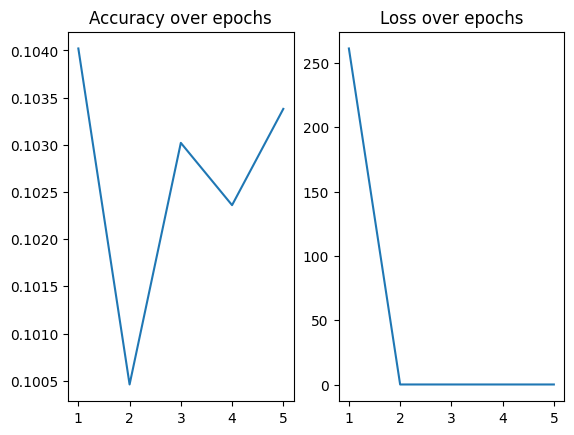

In [ ]:
#FOR BASIC MODEL
Parser = argparse.ArgumentParser()
#Parser.add_argument('--BasePath', default='/content/drive/MyDrive/Phase2/CIFAR10', help='Base path of images, Default:/media/nitin/Research/Homing/SpectralCompression/CIFAR10')
Parser.add_argument('--BasePath', default='/home/rashmikapu/Downloads/YourDirectoryID_hw0(1)/YourDirectoryID_hw0/Phase2/CIFAR10', help='Base path of images, Default:/media/nitin/Research/Homing/SpectralCompression/CIFAR10')
Parser.add_argument('--CheckPointPath', default='../Checkpoints/', help='Path to save Checkpoints, Default: ../Checkpoints/')
Parser.add_argument('--NumEpochs', type=int, default=5, help='Number of Epochs to Train for, Default:50')
Parser.add_argument('--DivTrain', type=int, default=1, help='Factor to reduce Train data by per epoch, Default:1')
Parser.add_argument('--MiniBatchSize', type=int, default=8, help='Size of the MiniBatch to use, Default:1')
Parser.add_argument('--LoadCheckPoint', type=int, default=0, help='Load Model from latest Checkpoint from CheckPointsPath?, Default:0')
Parser.add_argument('--LogsPath', default='Logs/', help='Path to save Logs for Tensorboard, Default=Logs/')

Args,_ = Parser.parse_known_args()
NumEpochs = Args.NumEpochs
BasePath = Args.BasePath
DivTrain = float(Args.DivTrain)
MiniBatchSize = Args.MiniBatchSize
LoadCheckPoint = Args.LoadCheckPoint
CheckPointPath = Args.CheckPointPath
LogsPath = Args.LogsPath

# Setup all needed parameters including file reading
DirNamesTrain, SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses = SetupAll(BasePath, CheckPointPath)



# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

print(ImageSize)
# Define PlaceHolder variables for Input and Predicted output
#ImgPH = tf.keras.Input(shape=(MiniBatchSize, ImageSize[0], ImageSize[1], ImageSize[2]),dtype=tf.float32)
#LabelPH = tf.keras.Input(shape=(MiniBatchSize, NumClasses),dtype=tf.float32) # OneHOT labels
ImgPH = tf.compat.v1.placeholder(tf.float32, shape=(MiniBatchSize, ImageSize[0], ImageSize[1], ImageSize[2]))
print(ImgPH.shape)
LabelPH = tf.compat.v1.placeholder(tf.float32, shape=(MiniBatchSize, NumClasses)) # OneHOT labels
TrainLabels = list(TrainLabels)
TrainOperation2(ImgPH, LabelPH, DirNamesTrain, TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, BasePath, LogsPath)

In [ ]:
#For RESNET MODEL
"""
  Inputs:
  None
  Outputs:
  Runs the Training and testing code based on the Flag
  """
# Parse Command Line arguments
Parser = argparse.ArgumentParser()
#Parser.add_argument('--BasePath', default='/content/drive/MyDrive/Phase2/CIFAR10', help='Base path of images, Default:/media/nitin/Research/Homing/SpectralCompression/CIFAR10')
Parser.add_argument('--BasePath', default='/home/rashmikapu/Downloads/YourDirectoryID_hw0(1)/YourDirectoryID_hw0/Phase2/CIFAR10', help='Base path of images, Default:/media/nitin/Research/Homing/SpectralCompression/CIFAR10')
Parser.add_argument('--CheckPointPath', default='../Checkpoints/', help='Path to save Checkpoints, Default: ../Checkpoints/')
Parser.add_argument('--NumEpochs', type=int, default=5, help='Number of Epochs to Train for, Default:50')
Parser.add_argument('--DivTrain', type=int, default=1, help='Factor to reduce Train data by per epoch, Default:1')
Parser.add_argument('--MiniBatchSize', type=int, default=8, help='Size of the MiniBatch to use, Default:1')
Parser.add_argument('--LoadCheckPoint', type=int, default=0, help='Load Model from latest Checkpoint from CheckPointsPath?, Default:0')
Parser.add_argument('--LogsPath', default='Logs/', help='Path to save Logs for Tensorboard, Default=Logs/')

Args,_ = Parser.parse_known_args()
NumEpochs = Args.NumEpochs
BasePath = Args.BasePath
DivTrain = float(Args.DivTrain)
MiniBatchSize = Args.MiniBatchSize
LoadCheckPoint = Args.LoadCheckPoint
CheckPointPath = Args.CheckPointPath
LogsPath = Args.LogsPath

# Setup all needed parameters including file reading
DirNamesTrain, SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses = SetupAll(BasePath, CheckPointPath)



# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

print(ImageSize)
# Define PlaceHolder variables for Input and Predicted output
#ImgPH = tf.keras.Input(shape=(MiniBatchSize, ImageSize[0], ImageSize[1], ImageSize[2]),dtype=tf.float32)
#LabelPH = tf.keras.Input(shape=(MiniBatchSize, NumClasses),dtype=tf.float32) # OneHOT labels
ImgPH = tf.compat.v1.placeholder(tf.float32, shape=(MiniBatchSize, ImageSize[0], ImageSize[1], ImageSize[2]))
print(ImgPH.shape)
LabelPH = tf.compat.v1.placeholder(tf.float32, shape=(MiniBatchSize, NumClasses)) # OneHOT labels

TrainLabels = list(TrainLabels)
TrainOperation(ImgPH, LabelPH, DirNamesTrain, TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, BasePath, LogsPath)


Number of Epochs Training will run for 5
Factor of reduction in training data is 1.0
Mini Batch Size 8
Number of Training Images 50000
[32, 32, 3]
(8, 32, 32, 3)
Instructions for updating:
Colocations handled automatically by placer.


/home/rashmikapu/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024-02-17 17:08:01.352739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


New model initialized....


  0%|                                                  | 0/6250 [00:00<?, ?it/s]


../Checkpoints/0a0model.ckpt Model Saved...



  2%|▋                                       | 101/6250 [00:25<29:56,  3.42it/s]


../Checkpoints/0a100model.ckpt Model Saved...



  3%|█▎                                      | 201/6250 [00:47<29:27,  3.42it/s]


../Checkpoints/0a200model.ckpt Model Saved...



  5%|█▉                                      | 301/6250 [01:09<28:39,  3.46it/s]


../Checkpoints/0a300model.ckpt Model Saved...



  6%|██▌                                     | 401/6250 [01:31<28:48,  3.38it/s]


../Checkpoints/0a400model.ckpt Model Saved...



  8%|███▏                                    | 500/6250 [01:52<21:13,  4.52it/s]

Instructions for updating:
Use standard file APIs to delete files with this prefix.



  8%|███▏                                    | 501/6250 [01:53<28:54,  3.31it/s]


../Checkpoints/0a500model.ckpt Model Saved...



 10%|███▊                                    | 601/6250 [02:15<28:05,  3.35it/s]


../Checkpoints/0a600model.ckpt Model Saved...



 11%|████▍                                   | 701/6250 [02:38<29:48,  3.10it/s]


../Checkpoints/0a700model.ckpt Model Saved...



 13%|█████▏                                  | 801/6250 [03:00<26:21,  3.45it/s]


../Checkpoints/0a800model.ckpt Model Saved...



 14%|█████▊                                  | 901/6250 [03:22<25:38,  3.48it/s]


../Checkpoints/0a900model.ckpt Model Saved...



 16%|██████▏                                | 1001/6250 [03:44<25:23,  3.45it/s]


../Checkpoints/0a1000model.ckpt Model Saved...



 18%|██████▊                                | 1101/6250 [04:06<24:43,  3.47it/s]


../Checkpoints/0a1100model.ckpt Model Saved...



 19%|███████▍                               | 1201/6250 [04:28<24:01,  3.50it/s]


../Checkpoints/0a1200model.ckpt Model Saved...



 21%|████████                               | 1301/6250 [04:49<23:53,  3.45it/s]


../Checkpoints/0a1300model.ckpt Model Saved...



 22%|████████▋                              | 1401/6250 [05:11<23:32,  3.43it/s]


../Checkpoints/0a1400model.ckpt Model Saved...



 24%|█████████▎                             | 1501/6250 [05:33<23:34,  3.36it/s]


../Checkpoints/0a1500model.ckpt Model Saved...



 26%|█████████▉                             | 1601/6250 [05:55<22:54,  3.38it/s]


../Checkpoints/0a1600model.ckpt Model Saved...



 27%|██████████▌                            | 1701/6250 [06:16<22:13,  3.41it/s]


../Checkpoints/0a1700model.ckpt Model Saved...



 29%|███████████▏                           | 1801/6250 [06:38<21:09,  3.50it/s]


../Checkpoints/0a1800model.ckpt Model Saved...



 30%|███████████▊                           | 1901/6250 [07:00<20:44,  3.50it/s]


../Checkpoints/0a1900model.ckpt Model Saved...



 32%|████████████▍                          | 2001/6250 [07:21<20:31,  3.45it/s]


../Checkpoints/0a2000model.ckpt Model Saved...



 34%|█████████████                          | 2101/6250 [07:43<20:13,  3.42it/s]


../Checkpoints/0a2100model.ckpt Model Saved...



 35%|█████████████▋                         | 2201/6250 [08:05<20:00,  3.37it/s]


../Checkpoints/0a2200model.ckpt Model Saved...



 37%|██████████████▎                        | 2301/6250 [08:26<19:09,  3.43it/s]


../Checkpoints/0a2300model.ckpt Model Saved...



 38%|██████████████▉                        | 2401/6250 [08:48<18:19,  3.50it/s]


../Checkpoints/0a2400model.ckpt Model Saved...



 40%|███████████████▌                       | 2501/6250 [09:10<17:45,  3.52it/s]


../Checkpoints/0a2500model.ckpt Model Saved...



 42%|████████████████▏                      | 2601/6250 [09:31<17:46,  3.42it/s]


../Checkpoints/0a2600model.ckpt Model Saved...



 43%|████████████████▊                      | 2701/6250 [09:53<17:22,  3.40it/s]


../Checkpoints/0a2700model.ckpt Model Saved...



 45%|█████████████████▍                     | 2801/6250 [10:14<16:34,  3.47it/s]


../Checkpoints/0a2800model.ckpt Model Saved...



 46%|██████████████████                     | 2901/6250 [10:36<16:54,  3.30it/s]


../Checkpoints/0a2900model.ckpt Model Saved...



 48%|██████████████████▋                    | 3001/6250 [10:58<15:34,  3.48it/s]


../Checkpoints/0a3000model.ckpt Model Saved...



 50%|███████████████████▎                   | 3101/6250 [11:19<15:09,  3.46it/s]


../Checkpoints/0a3100model.ckpt Model Saved...



 51%|███████████████████▉                   | 3201/6250 [11:41<14:47,  3.44it/s]


../Checkpoints/0a3200model.ckpt Model Saved...



 53%|████████████████████▌                  | 3301/6250 [12:02<14:19,  3.43it/s]


../Checkpoints/0a3300model.ckpt Model Saved...



 54%|█████████████████████▏                 | 3401/6250 [12:24<13:34,  3.50it/s]


../Checkpoints/0a3400model.ckpt Model Saved...



 56%|█████████████████████▊                 | 3501/6250 [12:46<13:48,  3.32it/s]


../Checkpoints/0a3500model.ckpt Model Saved...



 58%|██████████████████████▍                | 3601/6250 [13:07<12:46,  3.46it/s]


../Checkpoints/0a3600model.ckpt Model Saved...



 59%|███████████████████████                | 3701/6250 [13:28<12:34,  3.38it/s]


../Checkpoints/0a3700model.ckpt Model Saved...



 61%|███████████████████████▋               | 3801/6250 [13:50<11:56,  3.42it/s]


../Checkpoints/0a3800model.ckpt Model Saved...



 62%|████████████████████████▎              | 3901/6250 [14:12<11:13,  3.49it/s]


../Checkpoints/0a3900model.ckpt Model Saved...



 64%|████████████████████████▉              | 4001/6250 [14:33<11:17,  3.32it/s]


../Checkpoints/0a4000model.ckpt Model Saved...



 66%|█████████████████████████▌             | 4101/6250 [14:55<10:36,  3.38it/s]


../Checkpoints/0a4100model.ckpt Model Saved...



 67%|██████████████████████████▏            | 4201/6250 [15:17<10:02,  3.40it/s]


../Checkpoints/0a4200model.ckpt Model Saved...



 69%|██████████████████████████▊            | 4301/6250 [15:39<09:41,  3.35it/s]


../Checkpoints/0a4300model.ckpt Model Saved...



 70%|███████████████████████████▍           | 4401/6250 [16:01<09:09,  3.37it/s]


../Checkpoints/0a4400model.ckpt Model Saved...



 72%|████████████████████████████           | 4501/6250 [16:23<08:38,  3.37it/s]


../Checkpoints/0a4500model.ckpt Model Saved...



 74%|████████████████████████████▋          | 4601/6250 [16:44<07:53,  3.48it/s]


../Checkpoints/0a4600model.ckpt Model Saved...



 75%|█████████████████████████████▎         | 4701/6250 [17:06<07:36,  3.39it/s]


../Checkpoints/0a4700model.ckpt Model Saved...



 77%|█████████████████████████████▉         | 4801/6250 [17:28<06:56,  3.48it/s]


../Checkpoints/0a4800model.ckpt Model Saved...



 78%|██████████████████████████████▌        | 4901/6250 [17:49<06:37,  3.39it/s]


../Checkpoints/0a4900model.ckpt Model Saved...



 80%|███████████████████████████████▏       | 5001/6250 [18:11<06:00,  3.46it/s]


../Checkpoints/0a5000model.ckpt Model Saved...



 82%|███████████████████████████████▊       | 5101/6250 [18:33<05:37,  3.40it/s]


../Checkpoints/0a5100model.ckpt Model Saved...



 83%|████████████████████████████████▍      | 5201/6250 [18:55<05:11,  3.37it/s]


../Checkpoints/0a5200model.ckpt Model Saved...



 85%|█████████████████████████████████      | 5301/6250 [19:16<04:35,  3.45it/s]


../Checkpoints/0a5300model.ckpt Model Saved...



 86%|█████████████████████████████████▋     | 5401/6250 [19:38<04:07,  3.43it/s]


../Checkpoints/0a5400model.ckpt Model Saved...



 88%|██████████████████████████████████▎    | 5501/6250 [20:00<03:41,  3.38it/s]


../Checkpoints/0a5500model.ckpt Model Saved...



 90%|██████████████████████████████████▉    | 5601/6250 [20:22<03:09,  3.43it/s]


../Checkpoints/0a5600model.ckpt Model Saved...



 91%|███████████████████████████████████▌   | 5701/6250 [20:44<02:36,  3.50it/s]


../Checkpoints/0a5700model.ckpt Model Saved...



 93%|████████████████████████████████████▏  | 5801/6250 [21:06<02:12,  3.39it/s]


../Checkpoints/0a5800model.ckpt Model Saved...



 94%|████████████████████████████████████▊  | 5901/6250 [21:27<01:41,  3.45it/s]


../Checkpoints/0a5900model.ckpt Model Saved...



 96%|█████████████████████████████████████▍ | 6001/6250 [21:49<01:12,  3.44it/s]


../Checkpoints/0a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████ | 6101/6250 [22:11<00:45,  3.25it/s]


../Checkpoints/0a6100model.ckpt Model Saved...



 99%|██████████████████████████████████████▋| 6201/6250 [22:33<00:14,  3.42it/s]


../Checkpoints/0a6200model.ckpt Model Saved...



 20%|████████▏                                | 1/5 [22:44<1:30:57, 1364.41s/it]


../Checkpoints/0model.ckpt Model Saved...



  0%|                                          | 1/6250 [00:00<49:55,  2.09it/s]


../Checkpoints/1a0model.ckpt Model Saved...



  2%|▋                                       | 101/6250 [00:22<31:22,  3.27it/s]


../Checkpoints/1a100model.ckpt Model Saved...



  3%|█▎                                      | 201/6250 [00:44<30:50,  3.27it/s]


../Checkpoints/1a200model.ckpt Model Saved...



  5%|█▉                                      | 302/6250 [01:05<25:09,  3.94it/s]


../Checkpoints/1a300model.ckpt Model Saved...



  6%|██▌                                     | 401/6250 [01:27<28:18,  3.44it/s]


../Checkpoints/1a400model.ckpt Model Saved...



  8%|███▏                                    | 501/6250 [01:48<27:54,  3.43it/s]


../Checkpoints/1a500model.ckpt Model Saved...



 10%|███▊                                    | 601/6250 [02:10<28:08,  3.34it/s]


../Checkpoints/1a600model.ckpt Model Saved...



 11%|████▍                                   | 701/6250 [02:33<25:34,  3.62it/s]


../Checkpoints/1a700model.ckpt Model Saved...



 13%|█████▏                                  | 802/6250 [02:53<23:30,  3.86it/s]


../Checkpoints/1a800model.ckpt Model Saved...



 14%|█████▊                                  | 902/6250 [03:13<23:11,  3.84it/s]


../Checkpoints/1a900model.ckpt Model Saved...



 16%|██████▎                                | 1002/6250 [03:32<20:22,  4.29it/s]


../Checkpoints/1a1000model.ckpt Model Saved...



 18%|██████▉                                | 1102/6250 [03:51<19:49,  4.33it/s]


../Checkpoints/1a1100model.ckpt Model Saved...



 19%|███████▌                               | 1202/6250 [04:11<19:30,  4.31it/s]


../Checkpoints/1a1200model.ckpt Model Saved...



 21%|████████                               | 1302/6250 [04:30<19:23,  4.25it/s]


../Checkpoints/1a1300model.ckpt Model Saved...



 22%|████████▋                              | 1402/6250 [04:49<18:55,  4.27it/s]


../Checkpoints/1a1400model.ckpt Model Saved...



 24%|█████████▎                             | 1502/6250 [05:09<19:29,  4.06it/s]


../Checkpoints/1a1500model.ckpt Model Saved...



 26%|█████████▉                             | 1602/6250 [05:29<19:21,  4.00it/s]


../Checkpoints/1a1600model.ckpt Model Saved...



 27%|██████████▌                            | 1702/6250 [05:48<18:23,  4.12it/s]


../Checkpoints/1a1700model.ckpt Model Saved...



 29%|███████████▏                           | 1802/6250 [06:07<17:10,  4.32it/s]


../Checkpoints/1a1800model.ckpt Model Saved...



 30%|███████████▊                           | 1902/6250 [06:26<17:07,  4.23it/s]


../Checkpoints/1a1900model.ckpt Model Saved...



 32%|████████████▍                          | 2002/6250 [06:46<16:24,  4.31it/s]


../Checkpoints/1a2000model.ckpt Model Saved...



 34%|█████████████                          | 2102/6250 [07:04<16:16,  4.25it/s]


../Checkpoints/1a2100model.ckpt Model Saved...



 35%|█████████████▋                         | 2202/6250 [07:23<16:23,  4.12it/s]


../Checkpoints/1a2200model.ckpt Model Saved...



 37%|██████████████▎                        | 2302/6250 [07:42<15:22,  4.28it/s]


../Checkpoints/1a2300model.ckpt Model Saved...



 38%|██████████████▉                        | 2402/6250 [08:01<14:47,  4.34it/s]


../Checkpoints/1a2400model.ckpt Model Saved...



 40%|███████████████▌                       | 2502/6250 [08:20<14:33,  4.29it/s]


../Checkpoints/1a2500model.ckpt Model Saved...



 42%|████████████████▏                      | 2602/6250 [08:39<14:20,  4.24it/s]


../Checkpoints/1a2600model.ckpt Model Saved...



 43%|████████████████▊                      | 2702/6250 [08:57<13:48,  4.28it/s]


../Checkpoints/1a2700model.ckpt Model Saved...



 45%|█████████████████▍                     | 2802/6250 [09:16<13:35,  4.23it/s]


../Checkpoints/1a2800model.ckpt Model Saved...



 46%|██████████████████                     | 2902/6250 [09:35<13:02,  4.28it/s]


../Checkpoints/1a2900model.ckpt Model Saved...



 48%|██████████████████▋                    | 3002/6250 [09:54<13:22,  4.05it/s]


../Checkpoints/1a3000model.ckpt Model Saved...



 50%|███████████████████▎                   | 3102/6250 [10:14<12:14,  4.29it/s]


../Checkpoints/1a3100model.ckpt Model Saved...



 51%|███████████████████▉                   | 3202/6250 [10:35<12:48,  3.96it/s]


../Checkpoints/1a3200model.ckpt Model Saved...



 53%|████████████████████▌                  | 3302/6250 [10:55<11:40,  4.21it/s]


../Checkpoints/1a3300model.ckpt Model Saved...



 54%|█████████████████████▏                 | 3402/6250 [11:14<11:15,  4.22it/s]


../Checkpoints/1a3400model.ckpt Model Saved...



 56%|█████████████████████▊                 | 3502/6250 [11:33<10:37,  4.31it/s]


../Checkpoints/1a3500model.ckpt Model Saved...



 58%|██████████████████████▍                | 3602/6250 [11:53<11:38,  3.79it/s]


../Checkpoints/1a3600model.ckpt Model Saved...



 59%|███████████████████████                | 3702/6250 [12:12<09:55,  4.28it/s]


../Checkpoints/1a3700model.ckpt Model Saved...



 61%|███████████████████████▋               | 3802/6250 [12:32<10:08,  4.02it/s]


../Checkpoints/1a3800model.ckpt Model Saved...



 62%|████████████████████████▎              | 3902/6250 [12:53<09:45,  4.01it/s]


../Checkpoints/1a3900model.ckpt Model Saved...



 64%|████████████████████████▉              | 4002/6250 [13:12<08:39,  4.33it/s]


../Checkpoints/1a4000model.ckpt Model Saved...



 66%|█████████████████████████▌             | 4101/6250 [13:31<10:17,  3.48it/s]


../Checkpoints/1a4100model.ckpt Model Saved...



 67%|██████████████████████████▏            | 4201/6250 [13:53<09:29,  3.60it/s]


../Checkpoints/1a4200model.ckpt Model Saved...



 69%|██████████████████████████▊            | 4302/6250 [14:16<07:47,  4.16it/s]


../Checkpoints/1a4300model.ckpt Model Saved...



 70%|███████████████████████████▍           | 4402/6250 [14:36<07:06,  4.33it/s]


../Checkpoints/1a4400model.ckpt Model Saved...



 72%|████████████████████████████           | 4502/6250 [14:57<07:33,  3.85it/s]


../Checkpoints/1a4500model.ckpt Model Saved...



 74%|████████████████████████████▋          | 4601/6250 [15:17<07:33,  3.63it/s]


../Checkpoints/1a4600model.ckpt Model Saved...



 75%|█████████████████████████████▎         | 4702/6250 [15:37<06:05,  4.23it/s]


../Checkpoints/1a4700model.ckpt Model Saved...



 77%|█████████████████████████████▉         | 4802/6250 [15:56<06:14,  3.87it/s]


../Checkpoints/1a4800model.ckpt Model Saved...



 78%|██████████████████████████████▌        | 4901/6250 [16:16<06:38,  3.39it/s]


../Checkpoints/1a4900model.ckpt Model Saved...



 80%|███████████████████████████████▏       | 5002/6250 [16:36<04:52,  4.27it/s]


../Checkpoints/1a5000model.ckpt Model Saved...



 82%|███████████████████████████████▊       | 5102/6250 [16:56<04:48,  3.98it/s]


../Checkpoints/1a5100model.ckpt Model Saved...



 83%|████████████████████████████████▍      | 5201/6250 [17:16<04:52,  3.59it/s]


../Checkpoints/1a5200model.ckpt Model Saved...



 85%|█████████████████████████████████      | 5302/6250 [17:37<04:13,  3.75it/s]


../Checkpoints/1a5300model.ckpt Model Saved...



 86%|█████████████████████████████████▋     | 5402/6250 [17:57<03:20,  4.23it/s]


../Checkpoints/1a5400model.ckpt Model Saved...



 88%|██████████████████████████████████▎    | 5501/6250 [18:17<03:28,  3.60it/s]


../Checkpoints/1a5500model.ckpt Model Saved...



 90%|██████████████████████████████████▉    | 5601/6250 [18:38<03:00,  3.59it/s]


../Checkpoints/1a5600model.ckpt Model Saved...



 91%|███████████████████████████████████▌   | 5702/6250 [18:58<02:07,  4.29it/s]


../Checkpoints/1a5700model.ckpt Model Saved...



 93%|████████████████████████████████████▏  | 5802/6250 [19:18<01:46,  4.20it/s]


../Checkpoints/1a5800model.ckpt Model Saved...



 94%|████████████████████████████████████▊  | 5901/6250 [19:39<01:45,  3.32it/s]


../Checkpoints/1a5900model.ckpt Model Saved...



 96%|█████████████████████████████████████▍ | 6001/6250 [20:01<01:14,  3.34it/s]


../Checkpoints/1a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████ | 6101/6250 [20:23<00:42,  3.54it/s]


../Checkpoints/1a6100model.ckpt Model Saved...



 99%|██████████████████████████████████████▋| 6202/6250 [20:42<00:11,  4.25it/s]


../Checkpoints/1a6200model.ckpt Model Saved...



 40%|████████████████▍                        | 2/5 [43:36<1:04:55, 1298.54s/it]


../Checkpoints/1model.ckpt Model Saved...



  0%|                                          | 2/6250 [00:00<29:25,  3.54it/s]


../Checkpoints/2a0model.ckpt Model Saved...



  2%|▋                                       | 102/6250 [00:19<24:09,  4.24it/s]


../Checkpoints/2a100model.ckpt Model Saved...



  3%|█▎                                      | 202/6250 [00:38<23:33,  4.28it/s]


../Checkpoints/2a200model.ckpt Model Saved...



  5%|█▉                                      | 302/6250 [00:57<23:33,  4.21it/s]


../Checkpoints/2a300model.ckpt Model Saved...



  6%|██▌                                     | 402/6250 [01:16<22:53,  4.26it/s]


../Checkpoints/2a400model.ckpt Model Saved...



  8%|███▏                                    | 502/6250 [01:35<22:29,  4.26it/s]


../Checkpoints/2a500model.ckpt Model Saved...



 10%|███▊                                    | 601/6250 [01:55<27:33,  3.42it/s]


../Checkpoints/2a600model.ckpt Model Saved...



 11%|████▍                                   | 701/6250 [02:17<27:22,  3.38it/s]


../Checkpoints/2a700model.ckpt Model Saved...



 13%|█████▏                                  | 801/6250 [02:39<26:22,  3.44it/s]


../Checkpoints/2a800model.ckpt Model Saved...



 14%|█████▊                                  | 901/6250 [03:01<25:50,  3.45it/s]


../Checkpoints/2a900model.ckpt Model Saved...



 16%|██████▏                                | 1001/6250 [03:23<25:49,  3.39it/s]


../Checkpoints/2a1000model.ckpt Model Saved...



 18%|██████▊                                | 1101/6250 [03:44<25:08,  3.41it/s]


../Checkpoints/2a1100model.ckpt Model Saved...



 19%|███████▍                               | 1201/6250 [04:06<24:46,  3.40it/s]


../Checkpoints/2a1200model.ckpt Model Saved...



 21%|████████                               | 1301/6250 [04:28<24:05,  3.42it/s]


../Checkpoints/2a1300model.ckpt Model Saved...



 22%|████████▋                              | 1401/6250 [04:50<23:40,  3.41it/s]


../Checkpoints/2a1400model.ckpt Model Saved...



 24%|█████████▎                             | 1501/6250 [05:11<23:03,  3.43it/s]


../Checkpoints/2a1500model.ckpt Model Saved...



 26%|█████████▉                             | 1601/6250 [05:33<22:32,  3.44it/s]


../Checkpoints/2a1600model.ckpt Model Saved...



 27%|██████████▌                            | 1701/6250 [05:55<21:49,  3.47it/s]


../Checkpoints/2a1700model.ckpt Model Saved...



 29%|███████████▏                           | 1801/6250 [06:16<22:23,  3.31it/s]


../Checkpoints/2a1800model.ckpt Model Saved...



 30%|███████████▊                           | 1901/6250 [06:38<21:14,  3.41it/s]


../Checkpoints/2a1900model.ckpt Model Saved...



 32%|████████████▍                          | 2001/6250 [07:00<20:33,  3.44it/s]


../Checkpoints/2a2000model.ckpt Model Saved...



 34%|█████████████                          | 2101/6250 [07:22<19:50,  3.48it/s]


../Checkpoints/2a2100model.ckpt Model Saved...



 35%|█████████████▋                         | 2201/6250 [07:44<19:49,  3.40it/s]


../Checkpoints/2a2200model.ckpt Model Saved...



 37%|██████████████▎                        | 2301/6250 [08:06<19:38,  3.35it/s]


../Checkpoints/2a2300model.ckpt Model Saved...



 38%|██████████████▉                        | 2401/6250 [08:27<19:12,  3.34it/s]


../Checkpoints/2a2400model.ckpt Model Saved...



 40%|███████████████▌                       | 2501/6250 [08:49<18:13,  3.43it/s]


../Checkpoints/2a2500model.ckpt Model Saved...



 42%|████████████████▏                      | 2601/6250 [09:11<17:21,  3.50it/s]


../Checkpoints/2a2600model.ckpt Model Saved...



 43%|████████████████▊                      | 2701/6250 [09:33<17:14,  3.43it/s]


../Checkpoints/2a2700model.ckpt Model Saved...



 45%|█████████████████▍                     | 2801/6250 [09:55<16:48,  3.42it/s]


../Checkpoints/2a2800model.ckpt Model Saved...



 46%|██████████████████                     | 2901/6250 [10:16<16:09,  3.45it/s]


../Checkpoints/2a2900model.ckpt Model Saved...



 48%|██████████████████▋                    | 3001/6250 [10:38<15:44,  3.44it/s]


../Checkpoints/2a3000model.ckpt Model Saved...



 50%|███████████████████▎                   | 3101/6250 [11:00<15:32,  3.38it/s]


../Checkpoints/2a3100model.ckpt Model Saved...



 51%|███████████████████▉                   | 3201/6250 [11:22<15:05,  3.37it/s]


../Checkpoints/2a3200model.ckpt Model Saved...



 53%|████████████████████▌                  | 3301/6250 [11:44<14:25,  3.41it/s]


../Checkpoints/2a3300model.ckpt Model Saved...



 54%|█████████████████████▏                 | 3401/6250 [12:06<13:37,  3.48it/s]


../Checkpoints/2a3400model.ckpt Model Saved...



 56%|█████████████████████▊                 | 3501/6250 [12:27<12:57,  3.53it/s]


../Checkpoints/2a3500model.ckpt Model Saved...



 58%|██████████████████████▍                | 3601/6250 [12:48<12:25,  3.55it/s]


../Checkpoints/2a3600model.ckpt Model Saved...



 59%|███████████████████████                | 3701/6250 [13:09<11:58,  3.55it/s]


../Checkpoints/2a3700model.ckpt Model Saved...



 61%|███████████████████████▋               | 3801/6250 [13:29<11:25,  3.57it/s]


../Checkpoints/2a3800model.ckpt Model Saved...



 62%|████████████████████████▎              | 3901/6250 [13:51<11:02,  3.55it/s]


../Checkpoints/2a3900model.ckpt Model Saved...



 64%|████████████████████████▉              | 4001/6250 [14:12<10:39,  3.52it/s]


../Checkpoints/2a4000model.ckpt Model Saved...



 66%|█████████████████████████▌             | 4101/6250 [14:32<10:05,  3.55it/s]


../Checkpoints/2a4100model.ckpt Model Saved...



 67%|██████████████████████████▏            | 4201/6250 [14:53<09:36,  3.56it/s]


../Checkpoints/2a4200model.ckpt Model Saved...



 69%|██████████████████████████▊            | 4301/6250 [15:14<09:06,  3.57it/s]


../Checkpoints/2a4300model.ckpt Model Saved...



 70%|███████████████████████████▍           | 4401/6250 [15:35<08:39,  3.56it/s]


../Checkpoints/2a4400model.ckpt Model Saved...



 72%|████████████████████████████           | 4501/6250 [15:56<08:11,  3.56it/s]


../Checkpoints/2a4500model.ckpt Model Saved...



 74%|████████████████████████████▋          | 4601/6250 [16:17<07:51,  3.50it/s]


../Checkpoints/2a4600model.ckpt Model Saved...



 75%|█████████████████████████████▎         | 4701/6250 [16:38<07:15,  3.56it/s]


../Checkpoints/2a4700model.ckpt Model Saved...



 77%|█████████████████████████████▉         | 4801/6250 [16:59<06:45,  3.57it/s]


../Checkpoints/2a4800model.ckpt Model Saved...



 78%|██████████████████████████████▌        | 4901/6250 [17:20<06:28,  3.48it/s]


../Checkpoints/2a4900model.ckpt Model Saved...



 80%|███████████████████████████████▏       | 5001/6250 [17:41<05:52,  3.55it/s]


../Checkpoints/2a5000model.ckpt Model Saved...



 82%|███████████████████████████████▊       | 5101/6250 [18:02<05:24,  3.54it/s]



../Checkpoints/2a5100model.ckpt Model Saved...


 83%|████████████████████████████████▍      | 5201/6250 [18:23<04:59,  3.50it/s]


../Checkpoints/2a5200model.ckpt Model Saved...



 85%|█████████████████████████████████      | 5301/6250 [18:44<04:25,  3.58it/s]


../Checkpoints/2a5300model.ckpt Model Saved...



 86%|█████████████████████████████████▋     | 5401/6250 [19:05<03:55,  3.61it/s]


../Checkpoints/2a5400model.ckpt Model Saved...



 88%|██████████████████████████████████▎    | 5501/6250 [19:26<03:34,  3.49it/s]


../Checkpoints/2a5500model.ckpt Model Saved...



 90%|██████████████████████████████████▉    | 5601/6250 [19:47<03:01,  3.57it/s]


../Checkpoints/2a5600model.ckpt Model Saved...



 91%|███████████████████████████████████▌   | 5701/6250 [20:08<02:35,  3.53it/s]


../Checkpoints/2a5700model.ckpt Model Saved...



 93%|████████████████████████████████████▏  | 5801/6250 [20:29<02:05,  3.58it/s]


../Checkpoints/2a5800model.ckpt Model Saved...



 94%|████████████████████████████████████▊  | 5901/6250 [20:50<01:39,  3.52it/s]


../Checkpoints/2a5900model.ckpt Model Saved...



 96%|█████████████████████████████████████▍ | 6001/6250 [21:11<01:10,  3.54it/s]


../Checkpoints/2a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████ | 6101/6250 [21:32<00:43,  3.46it/s]


../Checkpoints/2a6100model.ckpt Model Saved...



 99%|██████████████████████████████████████▋| 6201/6250 [21:53<00:13,  3.56it/s]


../Checkpoints/2a6200model.ckpt Model Saved...



 60%|████████████████████████▌                | 3/5 [1:05:40<43:39, 1309.97s/it]


../Checkpoints/2model.ckpt Model Saved...



  0%|                                          | 1/6250 [00:00<46:22,  2.25it/s]


../Checkpoints/3a0model.ckpt Model Saved...



  2%|▋                                       | 101/6250 [00:21<28:45,  3.56it/s]


../Checkpoints/3a100model.ckpt Model Saved...



  3%|█▎                                      | 201/6250 [00:42<28:31,  3.53it/s]


../Checkpoints/3a200model.ckpt Model Saved...



  5%|█▉                                      | 301/6250 [01:03<27:44,  3.57it/s]


../Checkpoints/3a300model.ckpt Model Saved...



  6%|██▌                                     | 401/6250 [01:24<27:43,  3.52it/s]


../Checkpoints/3a400model.ckpt Model Saved...



  8%|███▏                                    | 501/6250 [01:45<27:23,  3.50it/s]



../Checkpoints/3a500model.ckpt Model Saved...


 10%|███▊                                    | 601/6250 [02:06<26:28,  3.56it/s]


../Checkpoints/3a600model.ckpt Model Saved...



 11%|████▍                                   | 701/6250 [02:27<26:35,  3.48it/s]


../Checkpoints/3a700model.ckpt Model Saved...



 13%|█████▏                                  | 801/6250 [02:47<25:45,  3.52it/s]


../Checkpoints/3a800model.ckpt Model Saved...



 14%|█████▊                                  | 901/6250 [03:08<25:14,  3.53it/s]


../Checkpoints/3a900model.ckpt Model Saved...



 16%|██████▏                                | 1001/6250 [03:29<24:32,  3.56it/s]



../Checkpoints/3a1000model.ckpt Model Saved...


 18%|██████▊                                | 1101/6250 [03:50<24:31,  3.50it/s]


../Checkpoints/3a1100model.ckpt Model Saved...



 19%|███████▍                               | 1201/6250 [04:11<23:24,  3.60it/s]


../Checkpoints/3a1200model.ckpt Model Saved...



 21%|████████                               | 1301/6250 [04:32<23:25,  3.52it/s]


../Checkpoints/3a1300model.ckpt Model Saved...



 22%|████████▋                              | 1401/6250 [04:53<22:41,  3.56it/s]


../Checkpoints/3a1400model.ckpt Model Saved...



 24%|█████████▎                             | 1501/6250 [05:14<22:32,  3.51it/s]


../Checkpoints/3a1500model.ckpt Model Saved...



 26%|█████████▉                             | 1601/6250 [05:35<21:52,  3.54it/s]


../Checkpoints/3a1600model.ckpt Model Saved...



 27%|██████████▌                            | 1701/6250 [05:56<21:37,  3.51it/s]


../Checkpoints/3a1700model.ckpt Model Saved...



 29%|███████████▏                           | 1801/6250 [06:17<21:23,  3.46it/s]


../Checkpoints/3a1800model.ckpt Model Saved...



 30%|███████████▊                           | 1901/6250 [06:38<20:28,  3.54it/s]


../Checkpoints/3a1900model.ckpt Model Saved...



 32%|████████████▍                          | 2001/6250 [06:59<19:57,  3.55it/s]


../Checkpoints/3a2000model.ckpt Model Saved...



 34%|█████████████                          | 2101/6250 [07:19<19:54,  3.47it/s]


../Checkpoints/3a2100model.ckpt Model Saved...



 35%|█████████████▋                         | 2201/6250 [07:40<19:01,  3.55it/s]


../Checkpoints/3a2200model.ckpt Model Saved...



 37%|██████████████▎                        | 2301/6250 [08:01<18:30,  3.56it/s]


../Checkpoints/3a2300model.ckpt Model Saved...



 38%|██████████████▉                        | 2401/6250 [08:22<18:34,  3.45it/s]


../Checkpoints/3a2400model.ckpt Model Saved...



 40%|███████████████▌                       | 2501/6250 [08:43<17:26,  3.58it/s]


../Checkpoints/3a2500model.ckpt Model Saved...



 42%|████████████████▏                      | 2601/6250 [09:04<17:13,  3.53it/s]


../Checkpoints/3a2600model.ckpt Model Saved...



 43%|████████████████▊                      | 2701/6250 [09:25<17:34,  3.37it/s]


../Checkpoints/3a2700model.ckpt Model Saved...



 45%|█████████████████▍                     | 2801/6250 [09:46<16:16,  3.53it/s]


../Checkpoints/3a2800model.ckpt Model Saved...



 46%|██████████████████                     | 2901/6250 [10:07<16:00,  3.49it/s]


../Checkpoints/3a2900model.ckpt Model Saved...



 48%|██████████████████▋                    | 3001/6250 [10:28<15:14,  3.55it/s]


../Checkpoints/3a3000model.ckpt Model Saved...



 50%|███████████████████▎                   | 3101/6250 [10:49<14:39,  3.58it/s]


../Checkpoints/3a3100model.ckpt Model Saved...



 51%|███████████████████▉                   | 3201/6250 [11:10<14:25,  3.52it/s]


../Checkpoints/3a3200model.ckpt Model Saved...



 53%|████████████████████▌                  | 3301/6250 [11:30<13:45,  3.57it/s]


../Checkpoints/3a3300model.ckpt Model Saved...



 54%|█████████████████████▏                 | 3401/6250 [11:51<13:39,  3.47it/s]


../Checkpoints/3a3400model.ckpt Model Saved...



 56%|█████████████████████▊                 | 3501/6250 [12:12<12:52,  3.56it/s]


../Checkpoints/3a3500model.ckpt Model Saved...



 58%|██████████████████████▍                | 3601/6250 [12:33<12:29,  3.54it/s]


../Checkpoints/3a3600model.ckpt Model Saved...



 59%|███████████████████████                | 3701/6250 [12:54<12:02,  3.53it/s]


../Checkpoints/3a3700model.ckpt Model Saved...



 61%|███████████████████████▋               | 3801/6250 [13:15<11:23,  3.59it/s]


../Checkpoints/3a3800model.ckpt Model Saved...



 62%|████████████████████████▎              | 3901/6250 [13:36<10:58,  3.57it/s]


../Checkpoints/3a3900model.ckpt Model Saved...



 64%|████████████████████████▉              | 4001/6250 [13:57<10:26,  3.59it/s]


../Checkpoints/3a4000model.ckpt Model Saved...



 66%|█████████████████████████▌             | 4101/6250 [14:18<10:07,  3.54it/s]


../Checkpoints/3a4100model.ckpt Model Saved...



 67%|██████████████████████████▏            | 4201/6250 [14:39<09:38,  3.54it/s]


../Checkpoints/3a4200model.ckpt Model Saved...



 69%|██████████████████████████▊            | 4301/6250 [15:00<09:13,  3.52it/s]


../Checkpoints/3a4300model.ckpt Model Saved...



 70%|███████████████████████████▍           | 4401/6250 [15:20<08:34,  3.59it/s]


../Checkpoints/3a4400model.ckpt Model Saved...



 72%|████████████████████████████           | 4501/6250 [15:41<08:10,  3.56it/s]


../Checkpoints/3a4500model.ckpt Model Saved...



 74%|████████████████████████████▋          | 4601/6250 [16:02<07:47,  3.53it/s]


../Checkpoints/3a4600model.ckpt Model Saved...



 75%|█████████████████████████████▎         | 4701/6250 [16:23<07:20,  3.52it/s]


../Checkpoints/3a4700model.ckpt Model Saved...



 77%|█████████████████████████████▉         | 4801/6250 [16:44<06:50,  3.53it/s]


../Checkpoints/3a4800model.ckpt Model Saved...



 78%|██████████████████████████████▌        | 4901/6250 [17:05<06:19,  3.55it/s]


../Checkpoints/3a4900model.ckpt Model Saved...



 80%|███████████████████████████████▏       | 5001/6250 [17:26<05:59,  3.47it/s]


../Checkpoints/3a5000model.ckpt Model Saved...



 82%|███████████████████████████████▊       | 5101/6250 [17:47<05:22,  3.56it/s]


../Checkpoints/3a5100model.ckpt Model Saved...



 83%|████████████████████████████████▍      | 5201/6250 [18:08<04:53,  3.58it/s]


../Checkpoints/3a5200model.ckpt Model Saved...



 85%|█████████████████████████████████      | 5301/6250 [18:29<04:29,  3.52it/s]


../Checkpoints/3a5300model.ckpt Model Saved...



 86%|█████████████████████████████████▋     | 5401/6250 [18:49<03:57,  3.57it/s]


../Checkpoints/3a5400model.ckpt Model Saved...



 88%|██████████████████████████████████▎    | 5501/6250 [19:10<03:29,  3.58it/s]


../Checkpoints/3a5500model.ckpt Model Saved...



 90%|██████████████████████████████████▉    | 5601/6250 [19:31<03:02,  3.55it/s]


../Checkpoints/3a5600model.ckpt Model Saved...



 91%|███████████████████████████████████▌   | 5701/6250 [19:52<02:36,  3.51it/s]


../Checkpoints/3a5700model.ckpt Model Saved...



 93%|████████████████████████████████████▏  | 5801/6250 [20:13<02:05,  3.58it/s]


../Checkpoints/3a5800model.ckpt Model Saved...



 94%|████████████████████████████████████▊  | 5901/6250 [20:34<01:39,  3.51it/s]


../Checkpoints/3a5900model.ckpt Model Saved...



 96%|█████████████████████████████████████▍ | 6001/6250 [20:55<01:09,  3.59it/s]


../Checkpoints/3a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████ | 6101/6250 [21:16<00:41,  3.56it/s]


../Checkpoints/3a6100model.ckpt Model Saved...



 99%|██████████████████████████████████████▋| 6201/6250 [21:37<00:13,  3.55it/s]


../Checkpoints/3a6200model.ckpt Model Saved...



 80%|████████████████████████████████▊        | 4/5 [1:27:28<21:49, 1309.15s/it]


../Checkpoints/3model.ckpt Model Saved...



  0%|                                          | 1/6250 [00:00<47:39,  2.19it/s]


../Checkpoints/4a0model.ckpt Model Saved...



  2%|▋                                       | 101/6250 [00:21<28:26,  3.60it/s]


../Checkpoints/4a100model.ckpt Model Saved...



  3%|█▎                                      | 201/6250 [00:42<28:45,  3.50it/s]


../Checkpoints/4a200model.ckpt Model Saved...



  5%|█▉                                      | 301/6250 [01:03<28:07,  3.53it/s]


../Checkpoints/4a300model.ckpt Model Saved...



  6%|██▌                                     | 401/6250 [01:24<27:10,  3.59it/s]


../Checkpoints/4a400model.ckpt Model Saved...



  8%|███▏                                    | 501/6250 [01:45<27:17,  3.51it/s]


../Checkpoints/4a500model.ckpt Model Saved...



 10%|███▊                                    | 601/6250 [02:05<26:38,  3.53it/s]


../Checkpoints/4a600model.ckpt Model Saved...



 11%|████▍                                   | 701/6250 [02:26<26:11,  3.53it/s]


../Checkpoints/4a700model.ckpt Model Saved...



 13%|█████▏                                  | 801/6250 [02:47<25:32,  3.56it/s]


../Checkpoints/4a800model.ckpt Model Saved...



 14%|█████▊                                  | 901/6250 [03:08<25:28,  3.50it/s]


../Checkpoints/4a900model.ckpt Model Saved...



 16%|██████▏                                | 1001/6250 [03:29<24:32,  3.56it/s]


../Checkpoints/4a1000model.ckpt Model Saved...



 18%|██████▊                                | 1101/6250 [03:50<24:38,  3.48it/s]


../Checkpoints/4a1100model.ckpt Model Saved...



 19%|███████▍                               | 1201/6250 [04:11<23:34,  3.57it/s]


../Checkpoints/4a1200model.ckpt Model Saved...



 21%|████████                               | 1301/6250 [04:32<23:03,  3.58it/s]


../Checkpoints/4a1300model.ckpt Model Saved...



 22%|████████▋                              | 1401/6250 [04:53<22:52,  3.53it/s]


../Checkpoints/4a1400model.ckpt Model Saved...



 24%|█████████▎                             | 1501/6250 [05:13<22:16,  3.55it/s]


../Checkpoints/4a1500model.ckpt Model Saved...



 26%|█████████▉                             | 1601/6250 [05:34<21:41,  3.57it/s]


../Checkpoints/4a1600model.ckpt Model Saved...



 27%|██████████▌                            | 1701/6250 [05:55<21:32,  3.52it/s]


../Checkpoints/4a1700model.ckpt Model Saved...



 29%|███████████▏                           | 1801/6250 [06:16<21:18,  3.48it/s]


../Checkpoints/4a1800model.ckpt Model Saved...



 30%|███████████▊                           | 1901/6250 [06:37<20:37,  3.51it/s]


../Checkpoints/4a1900model.ckpt Model Saved...



 32%|████████████▍                          | 2001/6250 [06:58<19:56,  3.55it/s]


../Checkpoints/4a2000model.ckpt Model Saved...



 34%|█████████████                          | 2101/6250 [07:19<19:46,  3.50it/s]


../Checkpoints/4a2100model.ckpt Model Saved...



 35%|█████████████▋                         | 2201/6250 [07:40<19:46,  3.41it/s]


../Checkpoints/4a2200model.ckpt Model Saved...



 37%|██████████████▎                        | 2301/6250 [08:01<18:27,  3.56it/s]


../Checkpoints/4a2300model.ckpt Model Saved...



 38%|██████████████▉                        | 2401/6250 [08:22<18:02,  3.55it/s]


../Checkpoints/4a2400model.ckpt Model Saved...



 40%|███████████████▌                       | 2501/6250 [08:43<17:43,  3.53it/s]


../Checkpoints/4a2500model.ckpt Model Saved...



 42%|████████████████▏                      | 2601/6250 [09:04<17:41,  3.44it/s]


../Checkpoints/4a2600model.ckpt Model Saved...



 43%|████████████████▊                      | 2701/6250 [09:25<16:49,  3.52it/s]


../Checkpoints/4a2700model.ckpt Model Saved...



 45%|█████████████████▍                     | 2801/6250 [09:46<16:26,  3.50it/s]


../Checkpoints/4a2800model.ckpt Model Saved...



 46%|██████████████████                     | 2901/6250 [10:06<15:47,  3.53it/s]


../Checkpoints/4a2900model.ckpt Model Saved...



 48%|██████████████████▋                    | 3001/6250 [10:27<15:27,  3.50it/s]


../Checkpoints/4a3000model.ckpt Model Saved...



 50%|███████████████████▎                   | 3101/6250 [10:48<14:49,  3.54it/s]


../Checkpoints/4a3100model.ckpt Model Saved...



 51%|███████████████████▉                   | 3201/6250 [11:09<14:48,  3.43it/s]


../Checkpoints/4a3200model.ckpt Model Saved...



 53%|████████████████████▌                  | 3301/6250 [11:30<14:18,  3.44it/s]


../Checkpoints/4a3300model.ckpt Model Saved...



 54%|█████████████████████▏                 | 3402/6250 [11:51<12:08,  3.91it/s]


../Checkpoints/4a3400model.ckpt Model Saved...



 56%|█████████████████████▊                 | 3501/6250 [12:12<13:06,  3.50it/s]


../Checkpoints/4a3500model.ckpt Model Saved...



 58%|██████████████████████▍                | 3601/6250 [12:33<12:41,  3.48it/s]


../Checkpoints/4a3600model.ckpt Model Saved...



 59%|███████████████████████                | 3701/6250 [12:54<12:05,  3.51it/s]


../Checkpoints/4a3700model.ckpt Model Saved...



 61%|███████████████████████▋               | 3801/6250 [13:15<11:55,  3.42it/s]


../Checkpoints/4a3800model.ckpt Model Saved...



 62%|████████████████████████▎              | 3901/6250 [13:36<11:15,  3.48it/s]


../Checkpoints/4a3900model.ckpt Model Saved...



 64%|████████████████████████▉              | 4001/6250 [13:57<10:40,  3.51it/s]


../Checkpoints/4a4000model.ckpt Model Saved...



 66%|█████████████████████████▌             | 4101/6250 [14:19<10:04,  3.55it/s]


../Checkpoints/4a4100model.ckpt Model Saved...



 67%|██████████████████████████▏            | 4201/6250 [14:40<09:45,  3.50it/s]



../Checkpoints/4a4200model.ckpt Model Saved...


 69%|██████████████████████████▊            | 4301/6250 [15:00<09:11,  3.53it/s]


../Checkpoints/4a4300model.ckpt Model Saved...



 70%|███████████████████████████▍           | 4401/6250 [15:21<08:56,  3.45it/s]


../Checkpoints/4a4400model.ckpt Model Saved...



 72%|████████████████████████████           | 4501/6250 [15:42<08:33,  3.41it/s]


../Checkpoints/4a4500model.ckpt Model Saved...



 74%|████████████████████████████▋          | 4601/6250 [16:03<07:49,  3.51it/s]


../Checkpoints/4a4600model.ckpt Model Saved...



 75%|█████████████████████████████▎         | 4701/6250 [16:24<07:26,  3.47it/s]


../Checkpoints/4a4700model.ckpt Model Saved...



 77%|█████████████████████████████▉         | 4801/6250 [16:45<06:59,  3.45it/s]


../Checkpoints/4a4800model.ckpt Model Saved...



 78%|██████████████████████████████▌        | 4901/6250 [17:06<06:32,  3.43it/s]


../Checkpoints/4a4900model.ckpt Model Saved...



 80%|███████████████████████████████▏       | 5001/6250 [17:27<05:59,  3.48it/s]


../Checkpoints/4a5000model.ckpt Model Saved...



 82%|███████████████████████████████▊       | 5101/6250 [17:48<05:30,  3.47it/s]


../Checkpoints/4a5100model.ckpt Model Saved...



 83%|████████████████████████████████▍      | 5201/6250 [18:09<05:00,  3.49it/s]


../Checkpoints/4a5200model.ckpt Model Saved...



 85%|█████████████████████████████████      | 5301/6250 [18:30<04:32,  3.48it/s]


../Checkpoints/4a5300model.ckpt Model Saved...



 86%|█████████████████████████████████▋     | 5401/6250 [18:51<04:04,  3.47it/s]


../Checkpoints/4a5400model.ckpt Model Saved...



 88%|██████████████████████████████████▎    | 5501/6250 [19:12<03:35,  3.47it/s]


../Checkpoints/4a5500model.ckpt Model Saved...



 90%|██████████████████████████████████▉    | 5601/6250 [19:34<03:16,  3.31it/s]


../Checkpoints/4a5600model.ckpt Model Saved...



 91%|███████████████████████████████████▌   | 5701/6250 [19:56<02:45,  3.31it/s]


../Checkpoints/4a5700model.ckpt Model Saved...



 93%|████████████████████████████████████▏  | 5801/6250 [20:18<02:13,  3.36it/s]


../Checkpoints/4a5800model.ckpt Model Saved...



 94%|████████████████████████████████████▊  | 5901/6250 [20:40<01:45,  3.32it/s]


../Checkpoints/4a5900model.ckpt Model Saved...



 96%|█████████████████████████████████████▍ | 6001/6250 [21:02<01:12,  3.42it/s]


../Checkpoints/4a6000model.ckpt Model Saved...



 98%|██████████████████████████████████████ | 6101/6250 [21:23<00:44,  3.34it/s]


../Checkpoints/4a6100model.ckpt Model Saved...



 99%|██████████████████████████████████████▋| 6201/6250 [21:45<00:14,  3.35it/s]


../Checkpoints/4a6200model.ckpt Model Saved...



100%|█████████████████████████████████████████| 5/5 [1:49:25<00:00, 1313.02s/it]


../Checkpoints/4model.ckpt Model Saved...
